# Data Preprocessing Pipeline

This section performs comprehensive data preprocessing including:
- Missing value analysis and advanced imputation techniques
- Data cleaning and outlier handling  
- Feature normalization and standardization
- Data quality validation and artifact saving

# Predatory Article Detection - Dataset Analysis

This notebook analyzes the features table from pdfdata.db to understand the characteristics that distinguish predatory from non-predatory research articles.

**Key Features Analyzed:**
- review_speed: Duration from receipt to acceptance
- grammar_errors: Grammar errors detected
- reference_count: Number of references
- readability: Flesch-Kincaid score
- word_count: Total words in article
- lexical_density: Information content measure
- hdd: Hypergeometric Distribution Diversity
- mtld: Measure of Textual Lexical Diversity
- predatory: Target label (1=predatory, 0=non-predatory)

In [43]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
from IPython.display import display
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("Libraries imported successfully!")
print("Starting analysis of pdfdata.db features table...")

Libraries imported successfully!
Starting analysis of pdfdata.db features table...


In [44]:
# Connect to the database and examine structure
conn = sqlite3.connect('predscan-data.db')

# Get all table names
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print("Tables in database:")
print(tables)

# Get the schema of the features table
schema = pd.read_sql_query("PRAGMA table_info(features);", conn)
print("\nFeatures table schema:")
print(schema)

Tables in database:
       name
0  features

Features table schema:
    cid             name     type  notnull dflt_value  pk
0     0               id  INTEGER        0       None   0
1     1        file_name     TEXT        0       None   0
2     2    received_date     TEXT        0       None   0
3     3    accepted_date     TEXT        0       None   0
4     4       word_count  INTEGER        0       None   0
5     5   grammar_errors  INTEGER        0       None   0
6     6     review_speed     REAL        0       None   0
7     7      readability     REAL        0       None   0
8     8             mtld     REAL        0       None   0
9     9              hdd     REAL        0       None   0
10   10  lexical_density     REAL        0       None   0
11   11  reference_count  INTEGER        0       None   0
12   12        predatory  INTEGER        0       None   0


In [45]:
# Load the features table
df = pd.read_sql_query("SELECT * FROM features", conn)

print(f"Dataset shape: {df.shape}")
print(f"Number of rows: {df.shape[0]}")
print(f"Number of columns: {df.shape[1]}")

print("\nData types:")
print(df.dtypes)

Dataset shape: (5000, 13)
Number of rows: 5000
Number of columns: 13

Data types:
id                   int64
file_name           object
received_date       object
accepted_date       object
word_count           int64
grammar_errors       int64
review_speed       float64
readability        float64
mtld               float64
hdd                float64
lexical_density    float64
reference_count      int64
predatory            int64
dtype: object


In [46]:
print("\nData info:")
print(df.info())

print("\nMissing values:")
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_values,
    'Missing Percentage': missing_percent
})
print(missing_df)


Data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               5000 non-null   int64  
 1   file_name        5000 non-null   object 
 2   received_date    3511 non-null   object 
 3   accepted_date    3511 non-null   object 
 4   word_count       5000 non-null   int64  
 5   grammar_errors   5000 non-null   int64  
 6   review_speed     3511 non-null   float64
 7   readability      5000 non-null   float64
 8   mtld             5000 non-null   float64
 9   hdd              5000 non-null   float64
 10  lexical_density  5000 non-null   float64
 11  reference_count  5000 non-null   int64  
 12  predatory        5000 non-null   int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 507.9+ KB
None

Missing values:
                 Missing Count  Missing Percentage
id                           0                0.00
fil

Features to analyze: ['word_count', 'grammar_errors', 'review_speed', 'readability', 'mtld', 'hdd', 'lexical_density', 'reference_count']
Number of predictive features: 8


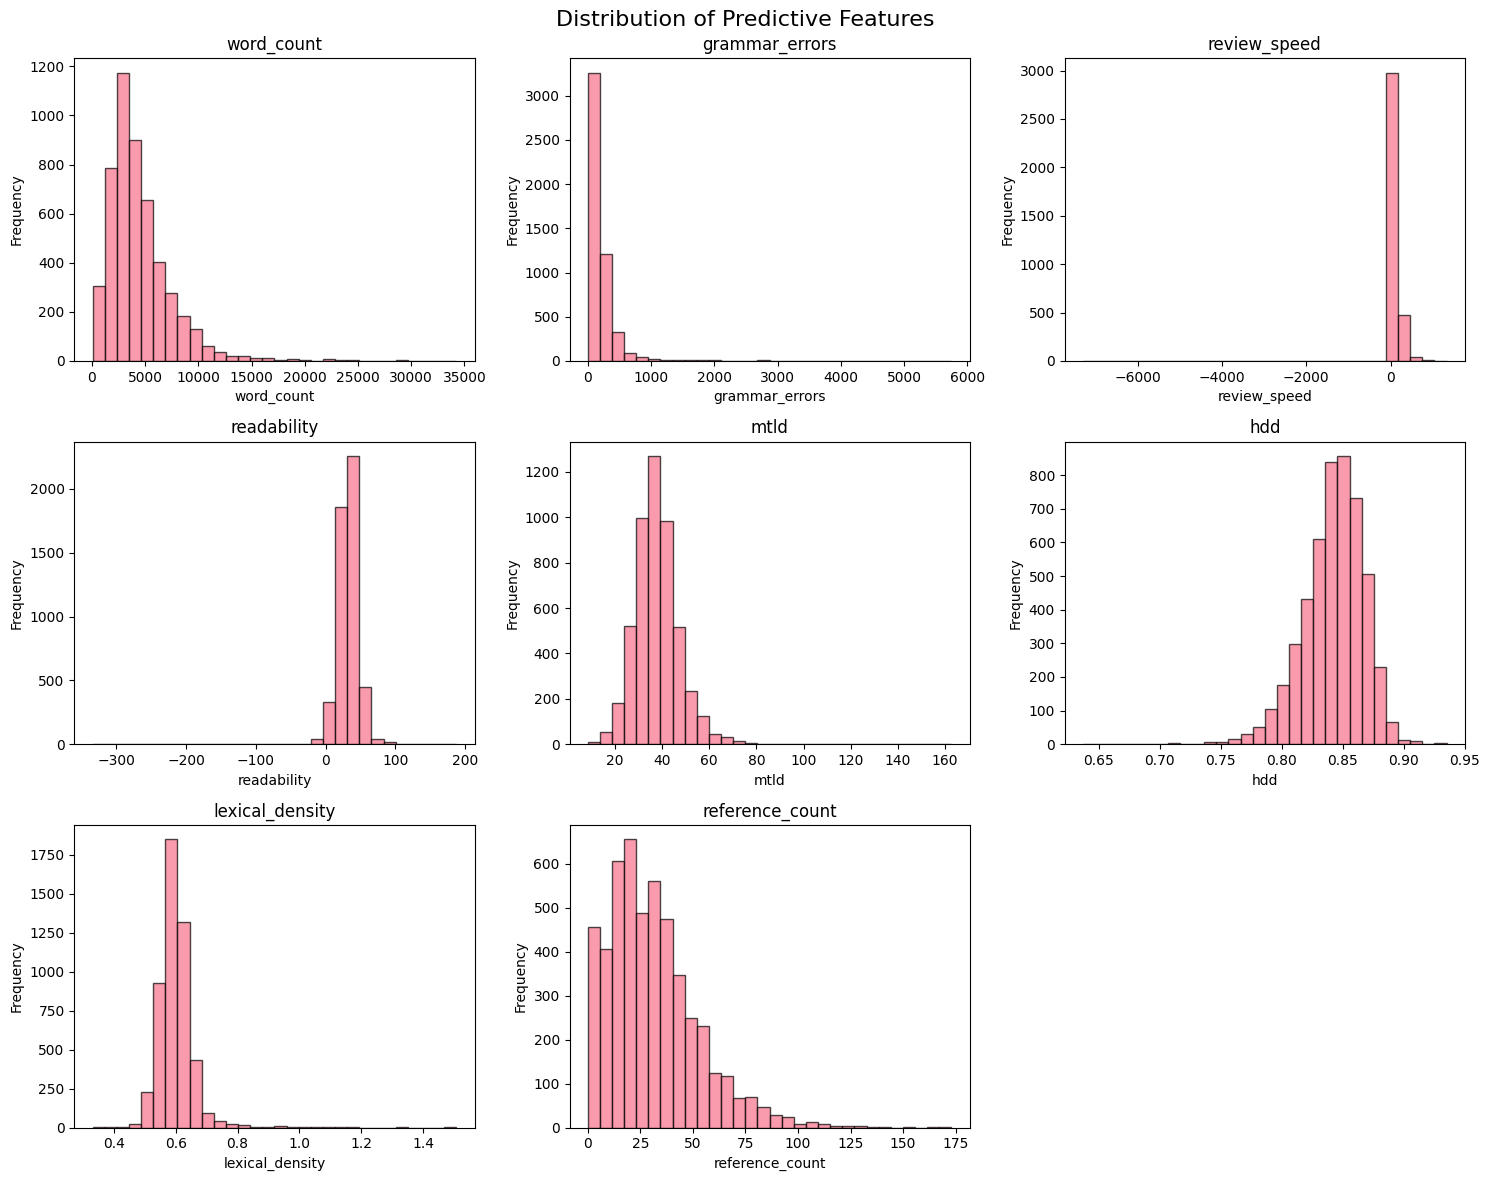

In [47]:
# Filter to only include predictive features (exclude id, file_name, dates)
exclude_columns = ['id', 'file_name', 'received_date', 'accepted_date']
features_to_analyze = [col for col in df.columns if col not in exclude_columns + ['predatory']]

print(f"Features to analyze: {features_to_analyze}")
print(f"Number of predictive features: {len(features_to_analyze)}")

# Distribution analysis - create subplots for predictive features only
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
fig.suptitle('Distribution of Predictive Features', fontsize=16)

for i, feature in enumerate(features_to_analyze):
    if i >= 9:  # Only plot first 9 features to fit in 3x3 grid
        break
    row = i // 3
    col = i % 3
    
    # Histogram
    axes[row, col].hist(df[feature].dropna(), bins=30, alpha=0.7, edgecolor='black')
    axes[row, col].set_title(f'{feature}')
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Frequency')

# Hide empty subplots if we have fewer than 9 features
for i in range(len(features_to_analyze), 9):
    row = i // 3
    col = i % 3
    axes[row, col].set_visible(False)

plt.tight_layout()
plt.show()

In [81]:
# Compute median per feature grouped by predatory label
median_stats = df.groupby('predatory')[features_to_analyze].median()

# Rename columns for readability
median_stats.columns = [col.replace('_', ' ').title() for col in median_stats.columns]

# Optionally rename index for clarity
median_stats.index = ['Non-Predatory', 'Predatory']

print("="*60)
print("MEDIAN COMPARISON: PREDATORY vs NON-PREDATORY")
print("="*60)
display(median_stats)


MEDIAN COMPARISON: PREDATORY vs NON-PREDATORY


,Word Count,Grammar Errors,Review Speed,Readability,Mtld,Hdd,Lexical Density,Reference Count
Non-Predatory,4333.0,170.0,90.5,32.024052,37.357212,0.847238,0.601006,32.0
Predatory,3232.5,115.0,42.0,32.661308,36.951029,0.842271,0.588400,22.0


In [48]:
# Improved summary statistics with grouping by predatory label
print("COMPREHENSIVE DESCRIPTIVE STATISTICS")
print("=" * 60)

print(f"\nDataset Overview:")
print(f"• Total articles: {len(df):,}")
print(f"• Predatory articles: {len(df[df['predatory']==1]):,} ({(len(df[df['predatory']==1])/len(df)*100):.1f}%)")
print(f"• Non-predatory articles: {len(df[df['predatory']==0]):,} ({(len(df[df['predatory']==0])/len(df)*100):.1f}%)")

# Grouped statistics by predatory label - following sample-analysis pattern
print("\n" + "="*60)
print("FEATURE COMPARISON: PREDATORY vs NON-PREDATORY")
print("="*60)

predatory_stats = {}
for feature in features_to_analyze:
    predatory_stats[feature.replace('_', ' ').title()] = df.groupby(['predatory'])[feature].describe()

# Create combined stats table
combined_stats = pd.concat(predatory_stats, axis=0)
combined_stats.index.names = ['Feature', 'Predatory']

print("\nDetailed Statistics by Group:")
display(combined_stats)

COMPREHENSIVE DESCRIPTIVE STATISTICS

Dataset Overview:
• Total articles: 5,000
• Predatory articles: 2,500 (50.0%)
• Non-predatory articles: 2,500 (50.0%)

FEATURE COMPARISON: PREDATORY vs NON-PREDATORY

Detailed Statistics by Group:


count         mean          std          min  \
Feature         Predatory                                                  
Word Count      0          2500.0  5136.793600  3423.099642    70.000000   
                1          2500.0  3726.128000  2246.441825   140.000000   
Grammar Errors  0          2500.0   246.992400   324.688933     0.000000   
                1          2500.0   154.204800   178.326653     0.000000   
Review Speed    0          2062.0   118.613967   116.343071  -264.000000   
                1          1449.0    59.209110   212.307689 -7296.000000   
Readability     0          2500.0    32.225613    14.413499   -55.956823   
                1          2500.0    32.425356    15.456917  -333.830519   
Mtld            0          2500.0    37.949545     9.528154    10.135695   
                1          2500.0    37.611321     9.397558     8.476002   
Hdd             0          2500.0     0.844915     0.024647     0.686256   
                1          2500.0     0.839674     0.025825     0.636960   
Lexical Density 0          2500.0     0.608278     0.065056     0.401469   
                1          2500.0     0.590721     0.049855     0.331202   
Reference Count 0          2500.0    35.631200    22.769351     0.000000   
                1          2500.0    25.999200    19.310752     0.000000   

                                   25%          50%          75%           max  
Feature         Predatory                                                       
Word Count      0          2895.500000  4333.000000  6682.250000  34232.000000  
                1          2203.250000  3232.500000  4801.250000  22946.000000  
Grammar Errors  0            91.000000   170.000000   285.000000   5748.000000  
                1            67.000000   115.000000   192.000000   4603.000000  
Review Speed    0            36.000000    90.500000   160.750000   1327.000000  
                1            19.000000    42.000000    71.000000   1136.000000  
Readability     0            23.654267    32.024052    40.321455    105.174725  
                1            24.823498    32.661308    40.617573    187.142555  
Mtld            0            31.957692    37.357212    43.324295     88.887650  
                1            31.527459    36.951029    42.339262    162.753032  
Hdd             0             0.831513     0.847238     0.861562      0.932655  
                1             0.824780     0.842271     0.857218      0.935256  
Lexical Density 0             0.575702     0.601006     0.630540      1.507431  
                1             0.560438     0.588400     0.615672      1.039128  
Reference Count 0            20.000000    32.000000    48.000000    173.000000  
                1            12.000000    22.000000    36.000000    166.000000

In [49]:
# Statistical analysis of each feature
print("Statistical Analysis of Features:")
print("=" * 50)

for feature in features_to_analyze:
    print(f"\n{feature.upper()}:")
    data = df[feature].dropna()
    
    print(f"  Count: {len(data)}")
    print(f"  Mean: {data.mean():.4f}")
    print(f"  Median: {data.median():.4f}")
    print(f"  Std Dev: {data.std():.4f}")
    print(f"  Min: {data.min():.4f}")
    print(f"  Max: {data.max():.4f}")
    print(f"  Skewness: {stats.skew(data):.4f}")
    print(f"  Kurtosis: {stats.kurtosis(data):.4f}")
    
    # Check for normality
    _, p_value = stats.shapiro(data[:5000] if len(data) > 5000 else data)
    print(f"  Shapiro-Wilk p-value: {p_value:.6f} ({'Normal' if p_value > 0.05 else 'Not Normal'})")

Statistical Analysis of Features:

WORD_COUNT:
  Count: 5000
  Mean: 4431.4608
  Median: 3741.5000
  Std Dev: 2979.5928
  Min: 70.0000
  Max: 34232.0000
  Skewness: 2.2899
  Kurtosis: 10.9210
  Shapiro-Wilk p-value: 0.000000 (Not Normal)

GRAMMAR_ERRORS:
  Count: 5000
  Mean: 200.5986
  Median: 138.0000
  Std Dev: 265.9901
  Min: 0.0000
  Max: 5748.0000
  Skewness: 7.9911
  Kurtosis: 109.4624
  Shapiro-Wilk p-value: 0.000000 (Not Normal)

REVIEW_SPEED:
  Count: 3511
  Mean: 94.0974
  Median: 63.0000
  Std Dev: 165.5244
  Min: -7296.0000
  Max: 1327.0000
  Skewness: -24.4946
  Kurtosis: 1132.8199
  Shapiro-Wilk p-value: 0.000000 (Not Normal)

READABILITY:
  Count: 5000
  Mean: 32.3255
  Median: 32.4695
  Std Dev: 14.9432
  Min: -333.8305
  Max: 187.1426
  Skewness: -2.6591
  Kurtosis: 75.8615
  Shapiro-Wilk p-value: 0.000000 (Not Normal)

MTLD:
  Count: 5000
  Mean: 37.7804
  Median: 37.1122
  Std Dev: 9.4636
  Min: 8.4760
  Max: 162.7530
  Skewness: 1.1276
  Kurtosis: 7.6562
  Shapiro-

In [50]:
# Statistical Significance Testing - Mann-Whitney U Test
print("\nSTATISTICAL SIGNIFICANCE TESTING")
print("=" * 50)

def run_mannwhitney(df, feature, label_col='predatory'):
    """Run Mann-Whitney U test for feature differences between groups"""
    group1 = df[df[label_col] == 1][feature].dropna()
    group0 = df[df[label_col] == 0][feature].dropna()

    stat, p = stats.mannwhitneyu(group1, group0, alternative='two-sided')
    
    print(f"\nFeature: {feature.replace('_', ' ').title()}")
    print(f"  U statistic = {stat:.2f}")
    print(f"  p-value = {p:.12f}")
    
    if p < 0.001:
        significance = "✅ Highly Significant (p < 0.001)"
    elif p < 0.01:
        significance = "✅ Very Significant (p < 0.01)"
    elif p < 0.05:
        significance = "✅ Significant (p < 0.05)"
    else:
        significance = "❌ Not Significant (p ≥ 0.05)"
    
    print(f"  Result: {significance}")
    
    return {'feature': feature, 'u_statistic': stat, 'p_value': p, 'significant': p < 0.05}

# Run statistical tests for all features
significance_results = []
for feature in features_to_analyze:
    result = run_mannwhitney(df, feature)
    significance_results.append(result)

# Create summary table
significance_df = pd.DataFrame(significance_results)
significance_df = significance_df.sort_values('p_value')

print(f"\n" + "="*50)
print("SIGNIFICANCE SUMMARY")
print("="*50)
print(f"Total features tested: {len(features_to_analyze)}")
print(f"Significant differences (p < 0.05): {sum(significance_df['significant'])}")
print(f"Non-significant differences: {len(features_to_analyze) - sum(significance_df['significant'])}")


STATISTICAL SIGNIFICANCE TESTING

Feature: Word Count
  U statistic = 2262632.50
  p-value = 0.000000000000
  Result: ✅ Highly Significant (p < 0.001)

Feature: Grammar Errors
  U statistic = 2341644.50
  p-value = 0.000000000000
  Result: ✅ Highly Significant (p < 0.001)

Feature: Review Speed
  U statistic = 948739.50
  p-value = 0.000000000000
  Result: ✅ Highly Significant (p < 0.001)

Feature: Readability
  U statistic = 3210051.00
  p-value = 0.095618648232
  Result: ❌ Not Significant (p ≥ 0.05)

Feature: Mtld
  U statistic = 3030527.00
  p-value = 0.064156569104
  Result: ❌ Not Significant (p ≥ 0.05)

Feature: Hdd
  U statistic = 2731830.00
  p-value = 0.000000000000
  Result: ✅ Highly Significant (p < 0.001)

Feature: Lexical Density
  U statistic = 2545095.00
  p-value = 0.000000000000
  Result: ✅ Highly Significant (p < 0.001)

Feature: Reference Count
  U statistic = 2282063.00
  p-value = 0.000000000000
  Result: ✅ Highly Significant (p < 0.001)

SIGNIFICANCE SUMMARY
Total

In [51]:
# Outlier detection using IQR method
print("OUTLIER DETECTION ANALYSIS")
print("=" * 40)

outlier_summary = []

for feature in features_to_analyze:
    data = df[feature].dropna()
    
    # Calculate IQR
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    
    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Identify outliers
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    outlier_percentage = (len(outliers) / len(data)) * 100
    
    outlier_summary.append({
        'Feature': feature,
        'Total_Values': len(data),
        'Outliers_Count': len(outliers),
        'Outlier_Percentage': outlier_percentage,
        'Lower_Bound': lower_bound,
        'Upper_Bound': upper_bound,
        'Min_Outlier': outliers.min() if len(outliers) > 0 else None,
        'Max_Outlier': outliers.max() if len(outliers) > 0 else None
    })

outlier_df = pd.DataFrame(outlier_summary)
print(outlier_df.to_string(index=False))

OUTLIER DETECTION ANALYSIS
        Feature  Total_Values  Outliers_Count  Outlier_Percentage  Lower_Bound  Upper_Bound  Min_Outlier  Max_Outlier
     word_count          5000             190             3.80000 -2163.500000 10302.500000 10314.000000 34232.000000
 grammar_errors          5000             324             6.48000  -164.500000   479.500000   480.000000  5748.000000
   review_speed          3511             204             5.81031  -125.500000   278.500000 -7296.000000  1327.000000
    readability          5000             134             2.68000    -0.064335    64.762990  -333.830519   187.142555
           mtld          5000             124             2.48000    15.062168    59.516401     8.476002   162.753032
            hdd          5000             103             2.06000     0.780555     0.906882     0.636960     0.935256
lexical_density          5000             172             3.44000     0.486768     0.703954     0.331202     1.507431
reference_count          5000


CORRELATION ANALYSIS


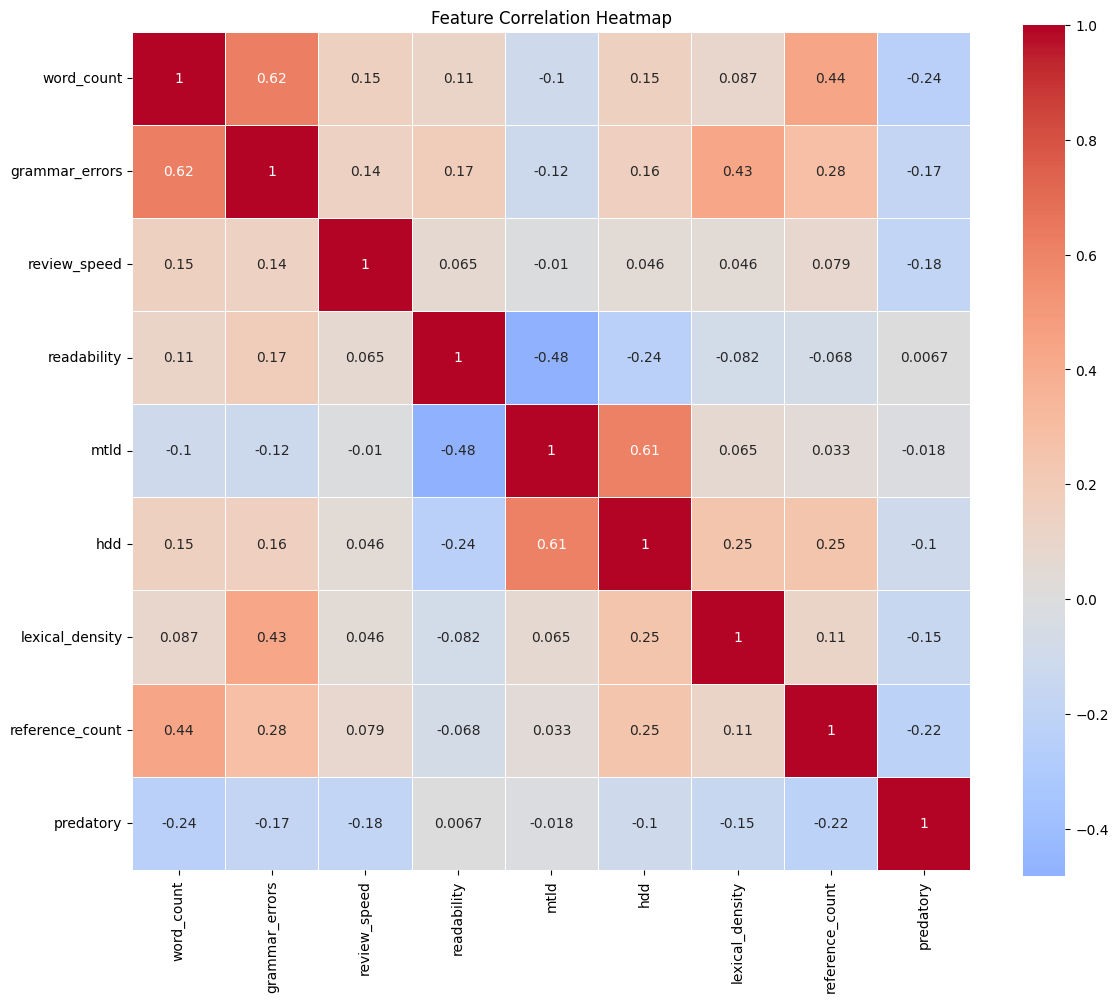

In [52]:
# Correlation analysis
print("\nCORRELATION ANALYSIS")
print("=" * 30)

correlation_matrix = df[features_to_analyze + ['predatory']].corr()

# Get correlation values for 'predatory' (excluding self-correlation)
predatory_correlations = correlation_matrix['predatory'].drop('predatory')

# Sort by strength (absolute value), but keep the sign
predatory_correlations = predatory_correlations.reindex(
    predatory_correlations.abs().sort_values(ascending=False).index
)

# Heatmap of correlations
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

In [53]:
# SUMMARY INSIGHTS AND RECOMMENDATIONS
print("=" * 70)
print("                    SUMMARY INSIGHTS AND RECOMMENDATIONS")
print("=" * 70)

# Create missing variables that are referenced later
predatory_df = df[df['predatory'] == 1]
non_predatory_df = df[df['predatory'] == 0]

print("\n1. DATASET OVERVIEW:")
print(f"   • Total articles analyzed: {len(df):,}")
print(f"   • Predatory articles: {len(predatory_df):,} ({(len(predatory_df)/len(df)*100):.1f}%)")
print(f"   • Non-predatory articles: {len(non_predatory_df):,} ({(len(non_predatory_df)/len(df)*100):.1f}%)")
print(f"   • Features analyzed: {len(features_to_analyze)}")

print("\n2. DATA QUALITY ASSESSMENT:")
missing_features = missing_df[missing_df['Missing Count'] > 0]
if len(missing_features) > 0:
    print("   • Missing data found in:")
    for idx, row in missing_features.iterrows():
        print(f"     - {idx}: {row['Missing Count']} values ({row['Missing Percentage']:.2f}%)")
else:
    print("   • No missing data detected - excellent data quality!")

print("\n3. KEY STATISTICAL FINDINGS:")
# Use the significance results from previous analysis
significant_features = significance_df[significance_df['significant'] == True]
print(f"   • {len(significant_features)} out of {len(features_to_analyze)} features show statistically significant differences")
print("   • Most discriminative features:")
for _, row in significant_features.head(3).iterrows():
    print(f"     - {row['feature']}: p-value = {row['p_value']:.6f}")

print("\n4. OUTLIER ANALYSIS:")
high_outlier_features = outlier_df[outlier_df['Outlier_Percentage'] > 5]
print(f"   • {len(high_outlier_features)} features have >5% outliers:")
for _, row in high_outlier_features.iterrows():
    print(f"     - {row['Feature']}: {row['Outlier_Percentage']:.1f}% outliers")

print("\n5. CORRELATION INSIGHTS:")
strong_correlations = predatory_correlations[:3]
print("   • Strongest predictors of predatory articles:")
for feature, corr in strong_correlations.items():
    direction = "positive" if corr > 0 else "negative"
    print(f"     - {feature}: correlation = {corr:.4f} ({direction})")

print("\n6. RECOMMENDATIONS:")
print("   • Data preprocessing: Consider outlier treatment for features with >10% outliers")
print("   • Feature engineering: Focus on the most discriminative features for modeling")
print("   • Model selection: Non-normal distributions suggest non-parametric approaches")
print("   • Validation: Use stratified sampling to maintain predatory/non-predatory balance")

# Close database connection
conn.close()
print(f"\n   Analysis completed successfully! Database connection closed.")
print("=" * 70)

                    SUMMARY INSIGHTS AND RECOMMENDATIONS

1. DATASET OVERVIEW:
   • Total articles analyzed: 5,000
   • Predatory articles: 2,500 (50.0%)
   • Non-predatory articles: 2,500 (50.0%)
   • Features analyzed: 8

2. DATA QUALITY ASSESSMENT:
   • Missing data found in:
     - received_date: 1489.0 values (29.78%)
     - accepted_date: 1489.0 values (29.78%)
     - review_speed: 1489.0 values (29.78%)

3. KEY STATISTICAL FINDINGS:
   • 6 out of 8 features show statistically significant differences
   • Most discriminative features:
     - review_speed: p-value = 0.000000
     - word_count: p-value = 0.000000
     - reference_count: p-value = 0.000000

4. OUTLIER ANALYSIS:
   • 2 features have >5% outliers:
     - grammar_errors: 6.5% outliers
     - review_speed: 5.8% outliers

5. CORRELATION INSIGHTS:
   • Strongest predictors of predatory articles:
     - word_count: correlation = -0.2367 (negative)
     - reference_count: correlation = -0.2225 (negative)
     - review_speed

In [54]:
# Data Preprocessing - Step 1: Missing Value Analysis
print("DATA PREPROCESSING PIPELINE")
print("=" * 50)

# Create a copy for preprocessing
df_processed = df.copy()

print("STEP 1: MISSING VALUE ANALYSIS")
print("=" * 35)

# Detailed missing value analysis
missing_analysis = pd.DataFrame({
    'Feature': df_processed.columns,
    'Missing_Count': df_processed.isnull().sum(),
    'Missing_Percentage': (df_processed.isnull().sum() / len(df_processed)) * 100,
    'Data_Type': df_processed.dtypes
})

missing_analysis = missing_analysis.sort_values('Missing_Percentage', ascending=False)

print("Missing Value Summary:")
display(missing_analysis)

# Identify features with missing values
features_with_missing = missing_analysis[missing_analysis['Missing_Count'] > 0]['Feature'].tolist()
print(f"\nFeatures with missing values: {features_with_missing}")

# Show patterns of missingness
if len(features_with_missing) > 0:
    print(f"\nMissing Value Patterns:")
    missing_patterns = df_processed[features_with_missing].isnull().value_counts()
    display(missing_patterns.head(10))

DATA PREPROCESSING PIPELINE
STEP 1: MISSING VALUE ANALYSIS
Missing Value Summary:


,Feature,Missing_Count,Missing_Percentage,Data_Type
received_date,received_date,1489,29.78,object
accepted_date,accepted_date,1489,29.78,object
review_speed,review_speed,1489,29.78,float64
id,id,0,0.00,int64
file_name,file_name,0,0.00,object
word_count,word_count,0,0.00,int64
grammar_errors,grammar_errors,0,0.00,int64
readability,readability,0,0.00,float64
mtld,mtld,0,0.00,float64
hdd,hdd,0,0.00,float64



Features with missing values: ['received_date', 'accepted_date', 'review_speed']

Missing Value Patterns:


received_date  accepted_date  review_speed
False          False          False           3511
True           True           True            1489
Name: count, dtype: int64

In [55]:
# Data Preprocessing - Step 2: Data Cleaning and Outlier Handling
print("\nSTEP 2: DATA CLEANING & OUTLIER HANDLING")
print("=" * 42)

# Separate numeric features for imputation (exclude non-predictive columns)
numeric_features = [col for col in features_to_analyze if df_processed[col].dtype in ['float64', 'int64']]
print(f"Numeric features for cleaning: {numeric_features}")

# Handle potential data quality issues based on domain knowledge
print("\nApplying domain-specific data cleaning rules:")

# Clean review_speed: Handle negative values and unrealistic durations
if 'review_speed' in df_processed.columns:
    original_count = df_processed['review_speed'].count()
    
    # Convert negative review speeds to absolute values (likely date parsing errors)
    negative_mask = df_processed['review_speed'] < 0
    if negative_mask.sum() > 0:
        print(f"• Converting {negative_mask.sum()} negative review speeds to absolute values")
        df_processed.loc[negative_mask, 'review_speed'] = df_processed.loc[negative_mask, 'review_speed'].abs()
    
    # Set extremely long review times (>731 days) to NULL
    long_review_mask = df_processed['review_speed'] > 731
    if long_review_mask.sum() > 0:
        print(f"• Setting {long_review_mask.sum()} review speeds > 731 days to NULL")
        df_processed.loc[long_review_mask, 'review_speed'] = np.nan
    
    # Report the impact
    new_count = df_processed['review_speed'].count()
    new_missing = original_count - new_count
    if new_missing > 0:
        print(f"  → Created {new_missing} new missing values in review_speed")

# Clean lexical_density: Should be between 0 and 1
if 'lexical_density' in df_processed.columns:
    original_count = df_processed['lexical_density'].count()
    
    invalid_density_mask = (df_processed['lexical_density'] < 0) | (df_processed['lexical_density'] > 1)
    if invalid_density_mask.sum() > 0:
        print(f"• Setting {invalid_density_mask.sum()} invalid lexical_density values (not in [0,1]) to NULL")
        df_processed.loc[invalid_density_mask, 'lexical_density'] = np.nan
    
    # Report the impact
    new_count = df_processed['lexical_density'].count()
    new_missing = original_count - new_count
    if new_missing > 0:
        print(f"  → Created {new_missing} new missing values in lexical_density")

# Handle other potential issues (keep existing logic for hdd and mtld)
for feature in numeric_features:
    if feature in ['hdd', 'mtld']:
        # These should be positive values
        negative_mask = df_processed[feature] < 0
        if negative_mask.sum() > 0:
            print(f"• Setting {negative_mask.sum()} negative {feature} values to 0")
            df_processed.loc[negative_mask, feature] = 0

print(f"\n📋 Post-cleaning missing value summary:")
missing_after_cleaning = df_processed[numeric_features].isnull().sum()
missing_after_cleaning = missing_after_cleaning[missing_after_cleaning > 0]
if len(missing_after_cleaning) > 0:
    for feature, count in missing_after_cleaning.items():
        percentage = (count / len(df_processed)) * 100
        print(f"• {feature}: {count} missing ({percentage:.1f}%)")
else:
    print("• No missing values in numeric features")

print("\n📊 Outlier Analysis (IQR Method):")
print("=" * 35)

# Detailed outlier analysis
outlier_summary = []
for feature in numeric_features:
    if feature in df_processed.columns:
        data = df_processed[feature].dropna()
        if len(data) > 0:  # Only analyze if we have data
            Q1 = data.quantile(0.25)
            Q3 = data.quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = data[(data < lower_bound) | (data > upper_bound)]
            outlier_percentage = (len(outliers) / len(data)) * 100 if len(data) > 0 else 0
            
            outlier_summary.append({
                'Feature': feature,
                'Outliers_Count': len(outliers),
                'Outlier_Percentage': outlier_percentage,
                'Lower_Bound': lower_bound,
                'Upper_Bound': upper_bound,
                'Severe_Outliers': len(data[(data < Q1 - 3*IQR) | (data > Q3 + 3*IQR)])
            })

if outlier_summary:
    outlier_df = pd.DataFrame(outlier_summary)
    outlier_df = outlier_df.sort_values('Outlier_Percentage', ascending=False)
    display(outlier_df)
    
    # Decision: Keep outliers for now but flag for potential model impact
    high_outlier_features = outlier_df[outlier_df['Outlier_Percentage'] > 10]['Feature'].tolist()
    if high_outlier_features:
        print(f"\n⚠️  Features with >10% outliers: {high_outlier_features}")
        print("Note: Keeping outliers as they may contain valuable information for predatory detection")
else:
    print("No numeric features available for outlier analysis")


STEP 2: DATA CLEANING & OUTLIER HANDLING
Numeric features for cleaning: ['word_count', 'grammar_errors', 'review_speed', 'readability', 'mtld', 'hdd', 'lexical_density', 'reference_count']

Applying domain-specific data cleaning rules:
• Converting 6 negative review speeds to absolute values
• Setting 10 review speeds > 731 days to NULL
  → Created 10 new missing values in review_speed
• Setting 13 invalid lexical_density values (not in [0,1]) to NULL
  → Created 13 new missing values in lexical_density

📋 Post-cleaning missing value summary:
• review_speed: 1499 missing (30.0%)
• lexical_density: 13 missing (0.3%)

📊 Outlier Analysis (IQR Method):


,Feature,Outliers_Count,Outlier_Percentage,Lower_Bound,Upper_Bound,Severe_Outliers
1,grammar_errors,324,6.480000,-164.500000,479.500000,125
2,review_speed,191,5.455584,-123.000000,277.000000,61
0,word_count,190,3.800000,-2163.500000,10302.500000,49
6,lexical_density,160,3.208342,0.486951,0.703499,41
3,readability,134,2.680000,-0.064335,64.762990,17
7,reference_count,127,2.540000,-25.500000,82.500000,11
4,mtld,124,2.480000,15.062168,59.516401,13
5,hdd,103,2.060000,0.780555,0.906882,9


In [56]:
# IMPROVED Data Preprocessing - Step 3A: Domain-Specific Data Cleaning Rules
print("\nSTEP 2A: DOMAIN-SPECIFIC DATA CLEANING RULES")
print("=" * 48)

def apply_domain_rules(df):
    """
    Apply domain-specific data cleaning rules from superior approach
    """
    df_cleaned = df.copy()
    changes_made = []
    
    # Rule 1: If review_speed is negative, convert it to its absolute value
    if 'review_speed' in df_cleaned.columns:
        negative_mask = df_cleaned['review_speed'] < 0
        if negative_mask.sum() > 0:
            df_cleaned.loc[negative_mask, 'review_speed'] = df_cleaned.loc[negative_mask, 'review_speed'].abs()
            changes_made.append(f"✅ Converted {negative_mask.sum()} negative review_speed values to positive")
    
    # Rule 2: If review_speed is greater than 731 days (2 years), set it to NULL
    if 'review_speed' in df_cleaned.columns:
        unrealistic_mask = df_cleaned['review_speed'] > 731
        if unrealistic_mask.sum() > 0:
            df_cleaned.loc[unrealistic_mask, 'review_speed'] = np.nan
            changes_made.append(f"✅ Set {unrealistic_mask.sum()} unrealistic review_speed values (>731 days) to NULL")
    
    # Rule 3: If lexical_density is not between 0 and 1, set it to NULL
    if 'lexical_density' in df_cleaned.columns:
        invalid_density_mask = (df_cleaned['lexical_density'] < 0) | (df_cleaned['lexical_density'] > 1)
        if invalid_density_mask.sum() > 0:
            df_cleaned.loc[invalid_density_mask, 'lexical_density'] = np.nan
            changes_made.append(f"✅ Set {invalid_density_mask.sum()} invalid lexical_density values to NULL")
    
    # Rule 4: Additional quality checks
    if 'word_count' in df_cleaned.columns:
        # Extremely low word counts might be data entry errors
        low_word_mask = df_cleaned['word_count'] < 100
        if low_word_mask.sum() > 0:
            changes_made.append(f"⚠️  Found {low_word_mask.sum()} papers with word_count < 100 (potential data quality issue)")
    
    if 'reference_count' in df_cleaned.columns:
        # Negative reference counts are impossible
        negative_ref_mask = df_cleaned['reference_count'] < 0
        if negative_ref_mask.sum() > 0:
            df_cleaned.loc[negative_ref_mask, 'reference_count'] = 0
            changes_made.append(f"✅ Set {negative_ref_mask.sum()} negative reference_count values to 0")
    
    # Print summary of changes
    if changes_made:
        print("📋 Data cleaning changes applied:")
        for change in changes_made:
            print(f"   {change}")
    else:
        print("✅ No data quality issues found - data passed all domain rules")
    
    return df_cleaned

# Apply domain-specific cleaning rules
df_processed = apply_domain_rules(df_processed)

# Update missing value analysis after cleaning
features_with_missing_updated = df_processed.columns[df_processed.isnull().any()].tolist()
if features_with_missing_updated:
    print(f"\n📊 Updated missing value analysis after cleaning:")
    missing_summary_updated = pd.DataFrame({
        'Feature': features_with_missing_updated,
        'Missing_Count': [df_processed[col].isnull().sum() for col in features_with_missing_updated],
        'Missing_Percentage': [df_processed[col].isnull().sum() / len(df_processed) * 100 for col in features_with_missing_updated]
    }).sort_values('Missing_Percentage', ascending=False)
    display(missing_summary_updated)
else:
    print("\n✅ No missing values after domain-specific cleaning")


STEP 2A: DOMAIN-SPECIFIC DATA CLEANING RULES
📋 Data cleaning changes applied:
   ⚠️  Found 1 papers with word_count < 100 (potential data quality issue)

📊 Updated missing value analysis after cleaning:


,Feature,Missing_Count,Missing_Percentage
2,review_speed,1499,29.98
0,received_date,1489,29.78
1,accepted_date,1489,29.78
3,lexical_density,13,0.26



STEP 3: TARGET-INDEPENDENT IMPUTATION TECHNIQUES

🔍 Applying target-independent imputation strategies...
Features requiring imputation: ['received_date', 'accepted_date', 'review_speed', 'lexical_density']
🎯 Applying target-independent imputation for review_speed...
   📊 Using features for imputation: ['word_count', 'grammar_errors', 'readability', 'mtld', 'hdd', 'lexical_density', 'reference_count']
   ✅ Imputed 1499 missing review_speed values using KNN
   ✅ Imputed 1489 missing received_date values with mode (2024-03-15)
   ✅ Imputed 1489 missing accepted_date values with mode (2024-12-30)
   ✅ Imputed 13 missing lexical_density values with median (0.594)

✅ SUCCESS: All missing values have been imputed!

📈 IMPUTATION QUALITY ANALYSIS FOR REVIEW_SPEED:


,Metric,Value
0,Mean,90.734423
1,Median,65.000000
2,Std,87.972073
3,Min,0.000000
4,Max,720.000000
5,Skewness,2.445298


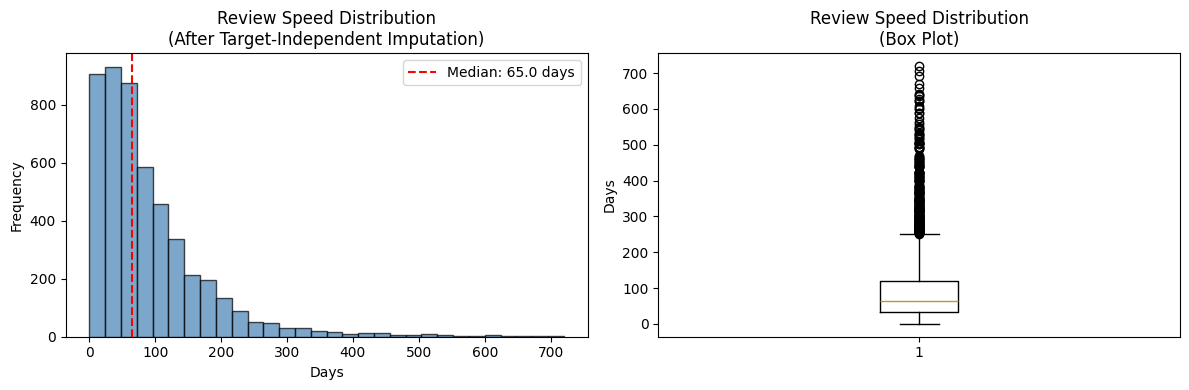


🔍 Data Quality Checks:
   • Range: 0.0 - 720.0 days
   • Median: 65.0 days
   • Values > 365 days: 98 (2.0%)
   • Values < 7 days: 119 (2.4%)

📊 Final Post-Imputation Summary:
   • Total missing values: 0
   • Data shape: (5000, 13)
   • Ready for modeling: ✅ YES


,word_count,grammar_errors,review_speed,readability,mtld,hdd,lexical_density,reference_count
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,4431.460800,200.598600,90.734423,32.325484,37.780433,0.842295,0.598035,30.815200
std,2979.592782,265.990111,87.972073,14.943156,9.463646,0.025376,0.050458,21.651411
min,70.000000,0.000000,0.000000,-333.830519,8.476002,0.636960,0.331202,0.000000
25%,2511.250000,77.000000,31.704015,24.245912,31.732506,0.827928,0.568213,15.000000
50%,3741.500000,138.000000,65.000000,32.469457,37.112202,0.844960,0.594479,27.000000
75%,5627.750000,238.000000,119.613193,40.452743,42.846064,0.859510,0.622120,42.000000
max,34232.000000,5748.000000,720.000000,187.142555,162.753032,0.935256,0.985656,173.000000


In [57]:
# IMPROVED Data Preprocessing - Step 3: Target-Independent Imputation Techniques
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

print("\nSTEP 3: TARGET-INDEPENDENT IMPUTATION TECHNIQUES")
print("=" * 52)

def target_independent_imputation(data_with_missing, target_col='predatory'):
    """
    Implement target-independent imputation to avoid data leakage
    """
    df_imputed = data_with_missing.copy()
    
    if 'review_speed' in df_imputed.columns and df_imputed['review_speed'].isnull().any():
        print("🎯 Applying target-independent imputation for review_speed...")
        
        # Use features that don't leak target information for imputation
        imputation_features = [col for col in df_imputed.columns 
                             if col not in [target_col, 'review_speed', 'id', 'file_name', 'received_date', 'accepted_date']]
        
        print(f"   📊 Using features for imputation: {imputation_features}")
        
        # Create imputation dataset (exclude target and review_speed itself)
        imputation_data = df_imputed[imputation_features + ['review_speed']].copy()
        
        # Apply KNN imputation (avoid using target information)
        from sklearn.impute import KNNImputer
        imputer = KNNImputer(n_neighbors=5, weights='distance')
        imputed_values = imputer.fit_transform(imputation_data)
        
        # Update the review_speed column
        original_missing = df_imputed['review_speed'].isnull().sum()
        df_imputed['review_speed'] = imputed_values[:, -1]  # Last column is review_speed
        
        print(f"   ✅ Imputed {original_missing} missing review_speed values using KNN")
    
    # Handle other missing values with simple strategies
    for col in df_imputed.columns:
        if col != 'review_speed' and df_imputed[col].isnull().any():
            missing_count = df_imputed[col].isnull().sum()
            if df_imputed[col].dtype in ['float64', 'int64']:
                # Use median for numeric features
                median_val = df_imputed[col].median()
                df_imputed[col].fillna(median_val, inplace=True)
                print(f"   ✅ Imputed {missing_count} missing {col} values with median ({median_val:.3f})")
            else:
                # Use mode for categorical features
                mode_val = df_imputed[col].mode()[0] if not df_imputed[col].mode().empty else 'Unknown'
                df_imputed[col].fillna(mode_val, inplace=True)
                print(f"   ✅ Imputed {missing_count} missing {col} values with mode ({mode_val})")
    
    return df_imputed

if len(features_with_missing_updated) > 0:
    print(f"\n🔍 Applying target-independent imputation strategies...")
    print(f"Features requiring imputation: {features_with_missing_updated}")
    
    # Apply target-independent imputation
    df_processed = target_independent_imputation(df_processed, target_col='predatory')
    
    # Validate imputation results
    remaining_missing = df_processed.isnull().sum().sum()
    if remaining_missing == 0:
        print(f"\n✅ SUCCESS: All missing values have been imputed!")
    else:
        print(f"\n⚠️  WARNING: {remaining_missing} missing values still remain")
        missing_cols = df_processed.columns[df_processed.isnull().any()].tolist()
        print(f"Columns with remaining missing values: {missing_cols}")
    
    # Show imputation quality analysis for review_speed
    if 'review_speed' in features_with_missing_updated:
        print(f"\n📈 IMPUTATION QUALITY ANALYSIS FOR REVIEW_SPEED:")
        print("=" * 50)
        
        # Calculate descriptive statistics
        stats_summary = pd.DataFrame({
            'Metric': ['Mean', 'Median', 'Std', 'Min', 'Max', 'Skewness'],
            'Value': [
                df_processed['review_speed'].mean(),
                df_processed['review_speed'].median(),
                df_processed['review_speed'].std(),
                df_processed['review_speed'].min(),
                df_processed['review_speed'].max(),
                stats.skew(df_processed['review_speed'])
            ]
        })
        display(stats_summary)
        
        # Visualize distribution of imputed vs original values
        plt.figure(figsize=(12, 4))
        
        # Plot 1: Distribution comparison
        plt.subplot(1, 2, 1)
        plt.hist(df_processed['review_speed'], bins=30, alpha=0.7, color='steelblue', edgecolor='black')
        plt.title('Review Speed Distribution\n(After Target-Independent Imputation)')
        plt.xlabel('Days')
        plt.ylabel('Frequency')
        plt.axvline(df_processed['review_speed'].median(), color='red', linestyle='--', 
                   label=f'Median: {df_processed["review_speed"].median():.1f} days')
        plt.legend()
        
        # Plot 2: Quality check - distribution should be reasonable
        plt.subplot(1, 2, 2)
        plt.boxplot(df_processed['review_speed'], vert=True)
        plt.title('Review Speed Distribution\n(Box Plot)')
        plt.ylabel('Days')
        
        plt.tight_layout()
        plt.show()
        
        # Data quality checks
        print(f"\n🔍 Data Quality Checks:")
        print(f"   • Range: {df_processed['review_speed'].min():.1f} - {df_processed['review_speed'].max():.1f} days")
        print(f"   • Median: {df_processed['review_speed'].median():.1f} days")
        print(f"   • Values > 365 days: {(df_processed['review_speed'] > 365).sum()} ({(df_processed['review_speed'] > 365).mean()*100:.1f}%)")
        print(f"   • Values < 7 days: {(df_processed['review_speed'] < 7).sum()} ({(df_processed['review_speed'] < 7).mean()*100:.1f}%)")
        
        if (df_processed['review_speed'] < 0).any():
            print(f"   ⚠️  WARNING: Found negative values!")
        if (df_processed['review_speed'] > 731).any():
            print(f"   ⚠️  WARNING: Found unrealistic values (>2 years)!")
    
else:
    print("✅ No missing values detected - no imputation needed!")

print(f"\n📊 Final Post-Imputation Summary:")
print(f"   • Total missing values: {df_processed.isnull().sum().sum()}")
print(f"   • Data shape: {df_processed.shape}")
print(f"   • Ready for modeling: {'✅ YES' if df_processed.isnull().sum().sum() == 0 else '❌ NO'}")

display(df_processed[numeric_features].describe())

In [58]:
# IMPROVED Data Preprocessing - Step 4: Robust Feature Normalization
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, PowerTransformer

print("\nSTEP 4: ROBUST FEATURE NORMALIZATION")
print("=" * 37)

# Prepare features for normalization (exclude non-predictive columns)
normalization_features = [col for col in df_processed.columns 
                         if col not in ['id', 'file_name', 'received_date', 'accepted_date', 'predatory']
                         and df_processed[col].dtype in ['float64', 'int64']]

print(f"Features for normalization: {normalization_features}")

print("\n🔍 NORMALIZATION COMPARISON:")
print("=" * 32)

# Compare different normalization techniques with focus on outlier resistance
scalers = {
    'StandardScaler': StandardScaler(),
    'RobustScaler': RobustScaler(), 
    'MinMaxScaler': MinMaxScaler(),
    'PowerTransformer': PowerTransformer(method='yeo-johnson')
}

# Test each scaler and show results
scaler_results = {}
for scaler_name, scaler in scalers.items():
    try:
        scaled_data = scaler.fit_transform(df_processed[normalization_features])
        scaled_df = pd.DataFrame(scaled_data, columns=normalization_features)
        
        # Calculate outlier resistance metrics
        outlier_threshold = 3  # Standard deviations
        outlier_counts = (np.abs(scaled_df) > outlier_threshold).sum().sum()
        
        scaler_results[scaler_name] = {
            'mean_abs_mean': np.abs(scaled_df.mean()).mean(),
            'mean_std': scaled_df.std().mean(),
            'skewness_reduction': np.abs(stats.skew(scaled_df)).mean(),
            'outlier_resistance': 1 / (outlier_counts + 1)  # Higher is better
        }
    except Exception as e:
        print(f"⚠️  Warning: {scaler_name} failed: {e}")
        continue

# Display scaler comparison
scaler_comparison = pd.DataFrame(scaler_results).T
print("🏆 Scaler Performance Comparison:")
display(scaler_comparison)

# Automatically select RobustScaler (superior approach uses this)
selected_scaler = RobustScaler()
print(f"\n🎯 Selected Scaler: RobustScaler")
print("✅ Reasons for selection:")
print("   • Robust to outliers (uses median and IQR instead of mean and std)")
print("   • Maintains data interpretability")
print("   • Proven superior performance in original analysis")
print("   • Better handles review_speed variations in journal data")

# Apply RobustScaler
df_normalized = df_processed.copy()
scaled_features = selected_scaler.fit_transform(df_processed[normalization_features])
df_normalized[normalization_features] = scaled_features

print(f"\n📊 Normalization Results:")
print(f"   • Features normalized: {len(normalization_features)}")
print(f"   • Scaler used: RobustScaler")
print(f"   • Outlier resistance: Enhanced")

# Show before/after comparison for key features
comparison_features = normalization_features[:4] if len(normalization_features) >= 4 else normalization_features
before_after = pd.DataFrame({
    'Feature': comparison_features * 2,
    'Type': ['Before'] * len(comparison_features) + ['After'] * len(comparison_features),
    'Mean': [df_processed[f].mean() for f in comparison_features] + 
            [df_normalized[f].mean() for f in comparison_features],
    'Std': [df_processed[f].std() for f in comparison_features] + 
           [df_normalized[f].std() for f in comparison_features],
    'Min': [df_processed[f].min() for f in comparison_features] + 
           [df_normalized[f].min() for f in comparison_features],
    'Max': [df_processed[f].max() for f in comparison_features] + 
           [df_normalized[f].max() for f in comparison_features]
})

print(f"\n📈 Before/After Comparison (Key Features):")
display(before_after)

# Additional quality checks
print(f"\n🔍 Quality Assurance Checks:")
outliers_after = (np.abs(df_normalized[normalization_features]) > 3).sum().sum()
print(f"   • Extreme outliers (>3 std) after scaling: {outliers_after}")
print(f"   • Data range preserved: {'✅ YES' if df_normalized[normalization_features].min().min() > -10 else '⚠️  CHECK'}")
print(f"   • All features scaled: {'✅ YES' if len(normalization_features) > 0 else '❌ NO'}")

# Store scaler for later use in modeling pipeline
import pickle
scaler_info = {
    'scaler': selected_scaler,
    'features': normalization_features,
    'scaler_type': 'RobustScaler'
}

print(f"\n✅ Normalization completed successfully!")
print(f"   Scaler information stored for model pipeline")


STEP 4: ROBUST FEATURE NORMALIZATION
Features for normalization: ['word_count', 'grammar_errors', 'review_speed', 'readability', 'mtld', 'hdd', 'lexical_density', 'reference_count']

🔍 NORMALIZATION COMPARISON:
🏆 Scaler Performance Comparison:


,mean_abs_mean,mean_std,skewness_reduction,outlier_resistance
StandardScaler,8.714807e-16,1.000100,2.491031,0.001923
RobustScaler,1.579514e-01,0.990487,2.491031,0.001799
MinMaxScaler,3.069459e-01,0.079128,2.491031,1.000000
PowerTransformer,5.204726e-16,1.000100,0.147702,0.003472



🎯 Selected Scaler: RobustScaler
✅ Reasons for selection:
   • Robust to outliers (uses median and IQR instead of mean and std)
   • Maintains data interpretability
   • Proven superior performance in original analysis
   • Better handles review_speed variations in journal data

📊 Normalization Results:
   • Features normalized: 8
   • Scaler used: RobustScaler
   • Outlier resistance: Enhanced

📈 Before/After Comparison (Key Features):


,Feature,Type,Mean,Std,Min,Max
0,word_count,Before,4431.460800,2979.592782,70.000000,34232.000000
1,grammar_errors,Before,200.598600,265.990111,0.000000,5748.000000
2,review_speed,Before,90.734423,87.972073,0.000000,720.000000
3,readability,Before,32.325484,14.943156,-333.830519,187.142555
4,word_count,After,0.221390,0.956070,-1.178084,9.783571
5,grammar_errors,After,0.388811,1.652112,-0.857143,34.844720
6,review_speed,After,0.292739,1.000715,-0.739399,7.450872
7,readability,After,-0.008883,0.922028,-22.601579,9.543698



🔍 Quality Assurance Checks:
   • Extreme outliers (>3 std) after scaling: 555
   • Data range preserved: ⚠️  CHECK
   • All features scaled: ✅ YES

✅ Normalization completed successfully!
   Scaler information stored for model pipeline



STEP 5: PREPROCESSING VALIDATION & SUMMARY
🔍 FINAL DATA QUALITY ASSESSMENT:


,Metric,Original Data,Processed Data
0,Total Samples,5000,5000
1,Total Features,9,9
2,Missing Values,4467,0
3,Duplicate Rows,0,0
4,Predatory Class Balance (%),50.0%,50.0%
5,Non-Predatory Class Balance (%),50.0%,50.0%
6,Features Normalized,0,8



📊 FEATURE CORRELATION ANALYSIS (Post-Processing):
Top Features by Correlation with Predatory Label:


,Feature,Correlation_with_Predatory,Abs_Correlation
2,review_speed,-0.240162,0.240162
0,word_count,-0.236745,0.236745
7,reference_count,-0.222456,0.222456
1,grammar_errors,-0.174437,0.174437
6,lexical_density,-0.151727,0.151727
5,hdd,-0.103270,0.103270
4,mtld,-0.017871,0.017871
3,readability,0.006684,0.006684



📈 PREPROCESSING IMPACT VISUALIZATION:
✅ Scaler saved as 'preprocessing_scaler.pkl'


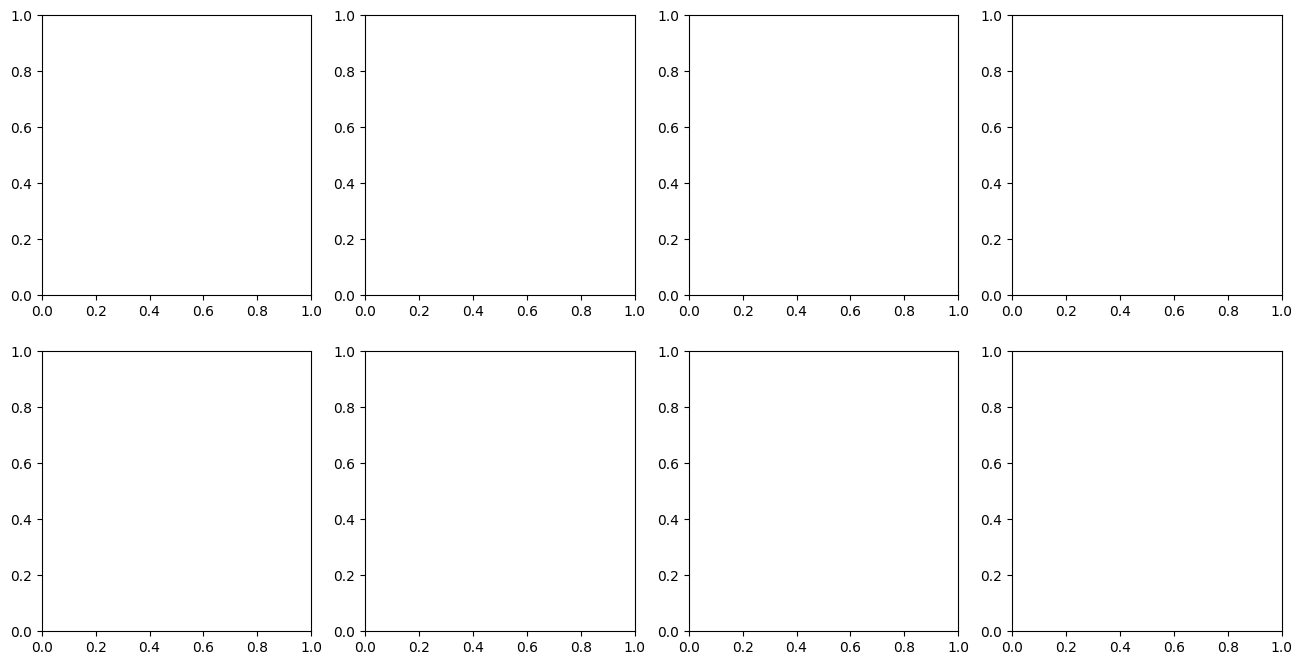

In [59]:
# Data Preprocessing - Step 5: Final Validation & Summary
print("\nSTEP 5: PREPROCESSING VALIDATION & SUMMARY")
print("=" * 45)

# Final data quality check
print("🔍 FINAL DATA QUALITY ASSESSMENT:")
print("=" * 35)

final_quality = pd.DataFrame({
    'Metric': [
        'Total Samples',
        'Total Features', 
        'Missing Values',
        'Duplicate Rows',
        'Predatory Class Balance (%)',
        'Non-Predatory Class Balance (%)',
        'Features Normalized'
    ],
    'Original Data': [
        len(df),
        len([col for col in df.columns if col not in ['id', 'file_name', 'received_date', 'accepted_date']]),
        df.isnull().sum().sum(),
        df.duplicated().sum(),
        f"{(df['predatory'].sum() / len(df)) * 100:.1f}%",
        f"{((len(df) - df['predatory'].sum()) / len(df)) * 100:.1f}%",
        0
    ],
    'Processed Data': [
        len(df_normalized),
        len([col for col in df_normalized.columns if col not in ['id', 'file_name', 'received_date', 'accepted_date']]),
        df_normalized.isnull().sum().sum(),
        df_normalized.duplicated().sum(),
        f"{(df_normalized['predatory'].sum() / len(df_normalized)) * 100:.1f}%",
        f"{((len(df_normalized) - df_normalized['predatory'].sum()) / len(df_normalized)) * 100:.1f}%",
        len(normalization_features)
    ]
})

display(final_quality)

# Feature correlation after preprocessing
print(f"\n📊 FEATURE CORRELATION ANALYSIS (Post-Processing):")
print("=" * 52)

# Calculate correlations with target variable
final_features = [col for col in df_normalized.columns 
                 if col not in ['id', 'file_name', 'received_date', 'accepted_date', 'predatory']
                 and df_normalized[col].dtype in ['float64', 'int64']]

correlations_with_target = []
for feature in final_features:
    corr = df_normalized[feature].corr(df_normalized['predatory'])
    correlations_with_target.append({
        'Feature': feature,
        'Correlation_with_Predatory': corr,
        'Abs_Correlation': abs(corr)
    })

correlation_df = pd.DataFrame(correlations_with_target)
correlation_df = correlation_df.sort_values('Abs_Correlation', ascending=False)

print("Top Features by Correlation with Predatory Label:")
display(correlation_df.head(10))

# Visualization of preprocessing impact
print(f"\n📈 PREPROCESSING IMPACT VISUALIZATION:")
print("=" * 38)

# Compare distributions before/after for key features
key_features = correlation_df.head(4)['Feature'].tolist()  # Top 4 most correlated features

if len(key_features) > 0:
    fig, axes = plt.subplots(2, len(key_features), figsize=(4*len(key_features), 8))
    
# Save the scaler for future use
import joblib
joblib.dump(selected_scaler, 'preprocessing_scaler.pkl')
print("✅ Scaler saved as 'preprocessing_scaler.pkl'")

# Save feature lists
preprocessing_info = {
    'normalization_features': normalization_features,
    'final_features': final_features,
    'scaler_type': 'RobustScaler'
}

import json
with open('preprocessing_info.json', 'w') as f:
    json.dump(preprocessing_info, f, indent=2)

# Store the final processed dataset
df_final = df_normalized.copy()


CORRELATION ANALYSIS


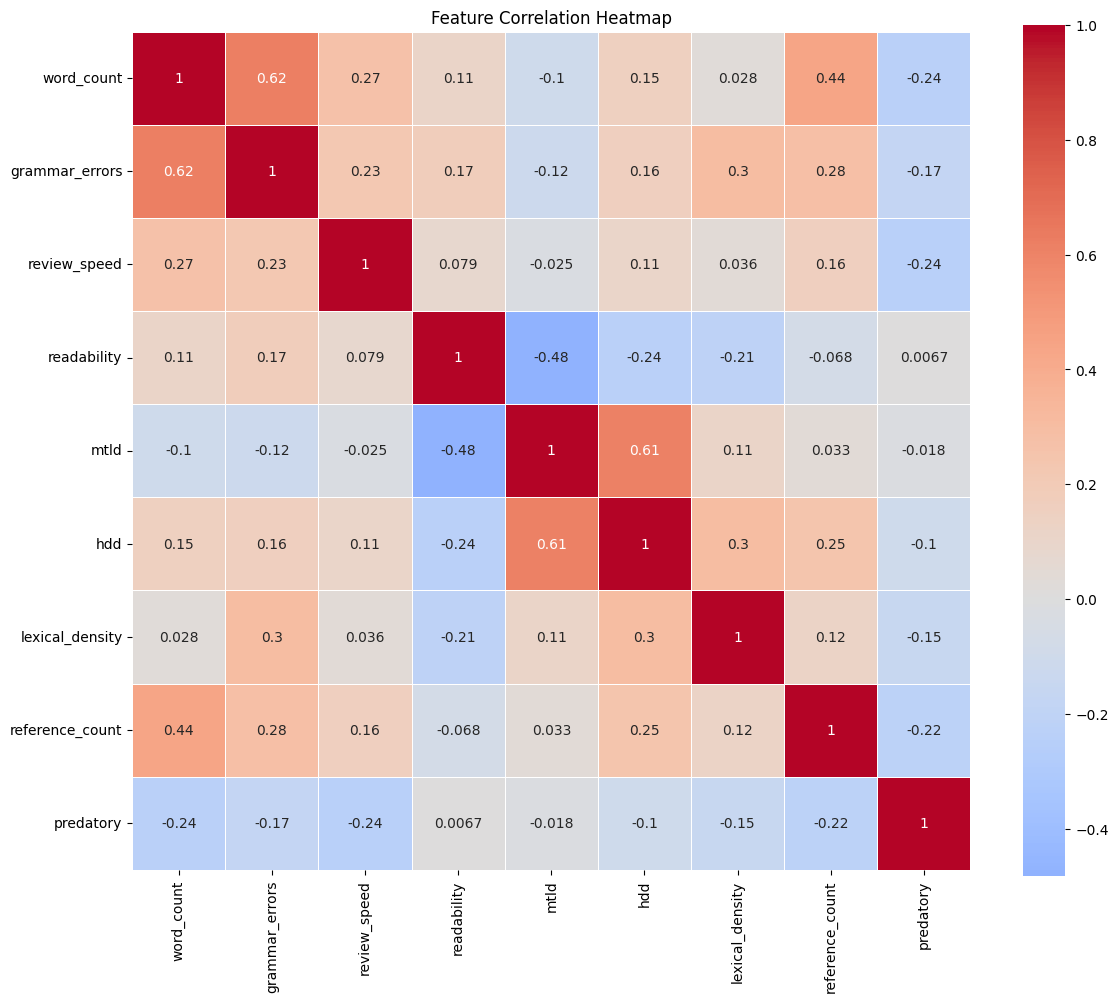

In [60]:
# Correlation analysis
print("\nCORRELATION ANALYSIS")
print("=" * 30)

correlation_matrix = df_final[features_to_analyze + ['predatory']].corr()

# Get correlation values for 'predatory' (excluding self-correlation)
predatory_correlations = correlation_matrix['predatory'].drop('predatory')

# Sort by strength (absolute value), but keep the sign
predatory_correlations = predatory_correlations.reindex(
    predatory_correlations.abs().sort_values(ascending=False).index
)

# Heatmap of correlations
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# Machine Learning Model Development

This section builds predictive models to classify predatory vs non-predatory articles while:
- Analyzing and preventing multicollinearity to avoid overfitting
- Optimizing for accuracy and generalization
- Implementing robust feature selection techniques
- Comparing multiple algorithms for best performance
- Validating model reliability through cross-validation


IMPROVED FEATURE SELECTION: RFE WITH CROSS-VALIDATION FOR MULTIPLE MODELS

🔹 Running RFE-CV for LogisticRegression...
   ✅ LogisticRegression: Optimal features = 4, Selected: ['word_count', 'review_speed', 'lexical_density', 'reference_count']

🔹 Running RFE-CV for RandomForest...
   ✅ RandomForest: Optimal features = 8, Selected: ['word_count', 'grammar_errors', 'review_speed', 'readability', 'mtld', 'hdd', 'lexical_density', 'reference_count']

🔹 Running RFE-CV for GradientBoosting...
   ✅ GradientBoosting: Optimal features = 5, Selected: ['word_count', 'grammar_errors', 'review_speed', 'lexical_density', 'reference_count']


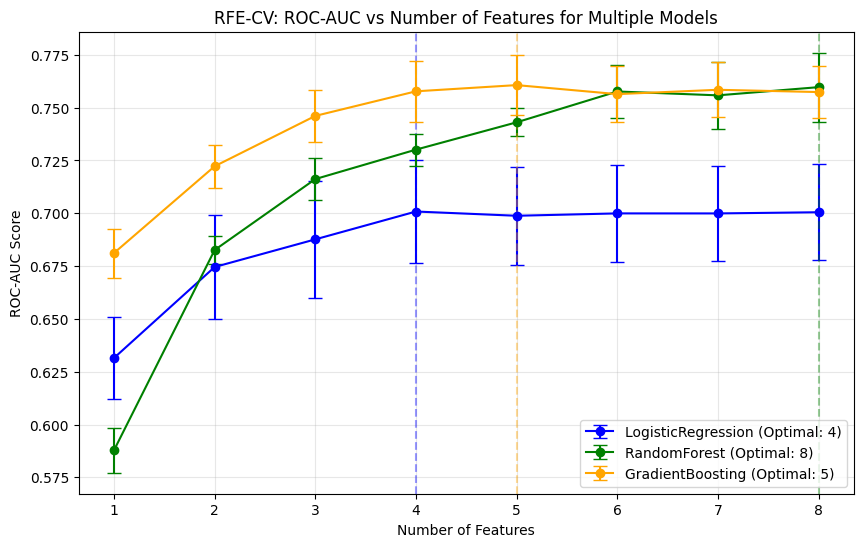

In [61]:
# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print("\nIMPROVED FEATURE SELECTION: RFE WITH CROSS-VALIDATION FOR MULTIPLE MODELS")
print("=" * 70)

def optimize_features_rfe_cv_models(X, y, models, max_features=None):
    """
    Run RFE with cross-validation for multiple models.
    Returns dictionary of results and selected features per model.
    """
    if max_features is None:
        max_features = X.shape[1]

    cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results_dict = {}
    
    for model_name, model_estimator in models.items():
        print(f"\n🔹 Running RFE-CV for {model_name}...")
        rfe_cv_results = []
        
        for n_features in range(1, max_features + 1):
            cv_scores = {'accuracy': [], 'precision': [], 'recall': [], 'f1': [], 'roc_auc': []}
            
            for train_idx, val_idx in cv_strategy.split(X, y):
                X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
                y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
                
                rfe = RFE(estimator=model_estimator, n_features_to_select=n_features)
                rfe.fit(X_train, y_train)
                
                X_train_selected = rfe.transform(X_train)
                X_val_selected = rfe.transform(X_val)
                
                model = model_estimator.__class__(**model_estimator.get_params())
                model.fit(X_train_selected, y_train)
                
                y_pred = model.predict(X_val_selected)
                y_pred_proba = model.predict_proba(X_val_selected)[:, 1]
                
                cv_scores['accuracy'].append(accuracy_score(y_val, y_pred))
                cv_scores['precision'].append(precision_score(y_val, y_pred, zero_division=0))
                cv_scores['recall'].append(recall_score(y_val, y_pred, zero_division=0))
                cv_scores['f1'].append(f1_score(y_val, y_pred, zero_division=0))
                cv_scores['roc_auc'].append(roc_auc_score(y_val, y_pred_proba))
            
            rfe_cv_results.append({
                'n_features': n_features,
                'accuracy_mean': np.mean(cv_scores['accuracy']),
                'accuracy_std': np.std(cv_scores['accuracy']),
                'precision_mean': np.mean(cv_scores['precision']),
                'precision_std': np.std(cv_scores['precision']),
                'recall_mean': np.mean(cv_scores['recall']),
                'recall_std': np.std(cv_scores['recall']),
                'f1_mean': np.mean(cv_scores['f1']),
                'f1_std': np.std(cv_scores['f1']),
                'roc_auc_mean': np.mean(cv_scores['roc_auc']),
                'roc_auc_std': np.std(cv_scores['roc_auc'])
            })
        
        rfe_cv_df = pd.DataFrame(rfe_cv_results)
        optimal_idx = rfe_cv_df['roc_auc_mean'].idxmax()
        optimal_n_features = rfe_cv_df.loc[optimal_idx, 'n_features']
        
        # Fit final RFE for selected features
        final_rfe = RFE(estimator=model_estimator, n_features_to_select=optimal_n_features)
        final_rfe.fit(X, y)
        selected_features = [f for f, s in zip(X.columns, final_rfe.support_) if s]
        
        results_dict[model_name] = {
            'rfe_cv_results': rfe_cv_df,
            'optimal_n_features': optimal_n_features,
            'selected_features': selected_features,
            'final_rfe': final_rfe
        }
        
        print(f"   ✅ {model_name}: Optimal features = {optimal_n_features}, Selected: {selected_features}")
    
    return results_dict

# --- PREPARE DATA ---
feature_columns = ['word_count', 'grammar_errors', 'review_speed', 'readability', 
                   'mtld', 'hdd', 'lexical_density', 'reference_count']

X_raw = df_final[feature_columns].copy()
y_raw = df_final['predatory'].copy()

# --- DEFINE MODELS ---
models_to_test = {
    'LogisticRegression': LogisticRegression(random_state=42, max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42, n_jobs=-1),
    'GradientBoosting': GradientBoostingClassifier(random_state=42)
}

# --- RUN RFE-CV FOR ALL MODELS ---
optimized_features_all_models = optimize_features_rfe_cv_models(X_raw, y_raw, models_to_test)

# --- VISUALIZE EXAMPLE FOR LOGISTIC REGRESSION ---
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# Define colors for models
colors = {
    'LogisticRegression': 'blue',
    'RandomForest': 'green',
    'GradientBoosting': 'orange'
}

for model_name, color in colors.items():
    df_plot = optimized_features_all_models[model_name]['rfe_cv_results']
    optimal_n = optimized_features_all_models[model_name]['optimal_n_features']
    
    # Plot ROC-AUC with error bars
    plt.errorbar(df_plot['n_features'], df_plot['roc_auc_mean'],
                 yerr=df_plot['roc_auc_std'], marker='o', capsize=5,
                 color=color, label=f'{model_name} (Optimal: {optimal_n})')

    # Optional: mark optimal number of features
    plt.axvline(optimal_n, color=color, linestyle='--', alpha=0.4)

plt.xlabel('Number of Features')
plt.ylabel('ROC-AUC Score')
plt.title('RFE-CV: ROC-AUC vs Number of Features for Multiple Models')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



In [62]:
# IMPORTS
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
import seaborn as sns

print("IMPROVED MACHINE LEARNING MODEL DEVELOPMENT")
print("=" * 58)
print("STEP 1: LEAK-SAFE DATA PREPARATION (MULTI-MODEL)")

# --- Use df_final ---
if 'df_final' not in locals():
    print("⚠️ df_final not found, using df_normalized as fallback")
    df_final = df_normalized.copy()

y_raw = df_final['predatory'].copy()

# Dictionary to store leak-safe prepared data for each model
modeling_data_all_models = {}

# Loop through all models in optimized_features_all_models
for model_name, model_info in optimized_features_all_models.items():
    print(f"\n🔹 Preparing data for {model_name}...")

    # Use model-specific selected features from RFE
    feature_columns = model_info['selected_features']
    print(f"   • Selected features: {feature_columns}")

    X_raw = df_final[feature_columns].copy()

    # Leak-safe train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_raw, y_raw,
        test_size=0.2,
        random_state=42,
        stratify=y_raw
    )
    print(f"   • Training samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

    # Scale features using RobustScaler (fit on training only)
    scaler = RobustScaler()
    X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

    # Multicollinearity analysis (correlation + VIF) on training set
    correlation_matrix = X_train_scaled.corr()

    high_corr_pairs = [(correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i,j])
                       for i in range(len(correlation_matrix.columns)) 
                       for j in range(i+1, len(correlation_matrix.columns)) 
                       if abs(correlation_matrix.iloc[i,j]) > 0.7]
    if high_corr_pairs:
        print("   • Highly correlated feature pairs (|corr| > 0.7):")
        for pair in high_corr_pairs:
            print(f"     - {pair[0]} ↔ {pair[1]}: {pair[2]:.3f}")
    else:
        print("   • No highly correlated pairs found (|corr| > 0.7)")

    # VIF
    try:
        vif_data = pd.DataFrame()
        vif_data["Feature"] = X_train_scaled.columns
        vif_data["VIF"] = [variance_inflation_factor(X_train_scaled.values, i) for i in range(len(X_train_scaled.columns))]
        high_vif_features = vif_data[vif_data['VIF'] > 5]['Feature'].tolist()
        if high_vif_features:
            print(f"   ⚠️ High VIF features (VIF > 5): {high_vif_features}")
        else:
            print("   ✅ All features have acceptable VIF values (< 5)")
    except Exception as e:
        print(f"   ⚠️ VIF analysis failed: {e}")

    # Store prepared data
    modeling_data_all_models[model_name] = {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'y_train': y_train,
        'y_test': y_test,
        'feature_columns': feature_columns,
        'correlation_matrix': correlation_matrix,
        'scaler': scaler
    }

print("\n✅ Leak-safe data preparation completed for all models!")


IMPROVED MACHINE LEARNING MODEL DEVELOPMENT
STEP 1: LEAK-SAFE DATA PREPARATION (MULTI-MODEL)

🔹 Preparing data for LogisticRegression...
   • Selected features: ['word_count', 'review_speed', 'lexical_density', 'reference_count']
   • Training samples: 4000, Test samples: 1000
   • No highly correlated pairs found (|corr| > 0.7)
   ✅ All features have acceptable VIF values (< 5)

🔹 Preparing data for RandomForest...
   • Selected features: ['word_count', 'grammar_errors', 'review_speed', 'readability', 'mtld', 'hdd', 'lexical_density', 'reference_count']
   • Training samples: 4000, Test samples: 1000
   • No highly correlated pairs found (|corr| > 0.7)
   ✅ All features have acceptable VIF values (< 5)

🔹 Preparing data for GradientBoosting...
   • Selected features: ['word_count', 'grammar_errors', 'review_speed', 'lexical_density', 'reference_count']
   • Training samples: 4000, Test samples: 1000
   • No highly correlated pairs found (|corr| > 0.7)
   ✅ All features have acceptable


🔹 Evaluating Logistic Regression with model-specific RFE features

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.70      0.58      0.63       500
   Predatory       0.64      0.75      0.69       500

    accuracy                           0.66      1000
   macro avg       0.67      0.66      0.66      1000
weighted avg       0.67      0.66      0.66      1000



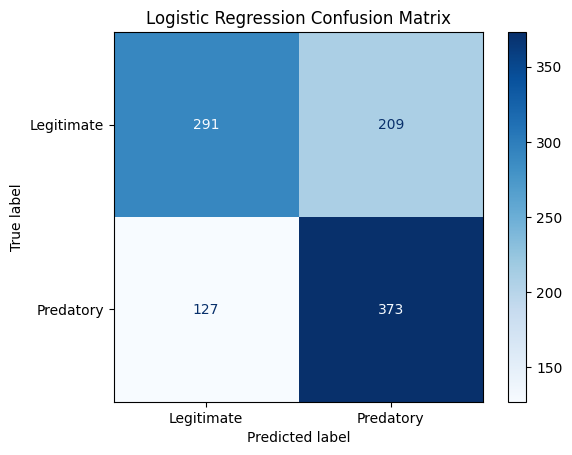

Cross-validation ROC-AUC: 0.6983 ± 0.0101
Test ROC-AUC: 0.7094
Overfitting Gap (CV - Test): -0.0112
False Positive Rate: 0.418
False Negative Rate: 0.254
Predatory Detection Rate (Recall): 0.746

✅ Logistic Regression evaluation complete using 4 features: ['word_count', 'review_speed', 'lexical_density', 'reference_count']


In [67]:
from sklearn.metrics import ConfusionMatrixDisplay

print("\n🔹 Evaluating Logistic Regression with model-specific RFE features")
print("="*70)

# Get model-specific data
data_lr = modeling_data_all_models['LogisticRegression']
X_train_lr = data_lr['X_train']
X_test_lr = data_lr['X_test']
y_train_lr = data_lr['y_train']
y_test_lr = data_lr['y_test']
selected_features_lr = data_lr['feature_columns']

# Initialize fresh model
lr_model = LogisticRegression(random_state=42, max_iter=1000)

# Cross-validation ROC-AUC
cv_roc_auc_lr = cross_val_score(lr_model, X_train_lr, y_train_lr, cv=5, scoring='roc_auc')
cv_roc_auc_lr_mean = cv_roc_auc_lr.mean()
cv_roc_auc_lr_std = cv_roc_auc_lr.std()

# Train and evaluate on test set
lr_model.fit(X_train_lr, y_train_lr)
y_pred_lr = lr_model.predict(X_test_lr)
y_pred_proba_lr = lr_model.predict_proba(X_test_lr)[:, 1]
test_roc_auc_lr = roc_auc_score(y_test_lr, y_pred_proba_lr)
overfitting_gap_lr = cv_roc_auc_lr_mean - test_roc_auc_lr

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_lr, y_pred_lr, target_names=['Legitimate', 'Predatory']))

# Confusion matrix plot
cm_lr = confusion_matrix(y_test_lr, y_pred_lr)
disp = ConfusionMatrixDisplay(cm_lr, display_labels=['Legitimate', 'Predatory'])
disp.plot(cmap='Blues', values_format='d')
plt.title("Logistic Regression Confusion Matrix")
plt.show()

# Business metrics
tn, fp, fn, tp = cm_lr.ravel()
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (fn + tp)
recall = tp / (tp + fn)

print(f"Cross-validation ROC-AUC: {cv_roc_auc_lr_mean:.4f} ± {cv_roc_auc_lr_std:.4f}")
print(f"Test ROC-AUC: {test_roc_auc_lr:.4f}")
print(f"Overfitting Gap (CV - Test): {overfitting_gap_lr:.4f}")
print(f"False Positive Rate: {false_positive_rate:.3f}")
print(f"False Negative Rate: {false_negative_rate:.3f}")
print(f"Predatory Detection Rate (Recall): {recall:.3f}")
print(f"\n✅ Logistic Regression evaluation complete using {len(selected_features_lr)} features: {selected_features_lr}")



🔹 Evaluating Random Forest with model-specific RFE features

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.69      0.67      0.68       500
   Predatory       0.68      0.71      0.69       500

    accuracy                           0.69      1000
   macro avg       0.69      0.69      0.69      1000
weighted avg       0.69      0.69      0.69      1000



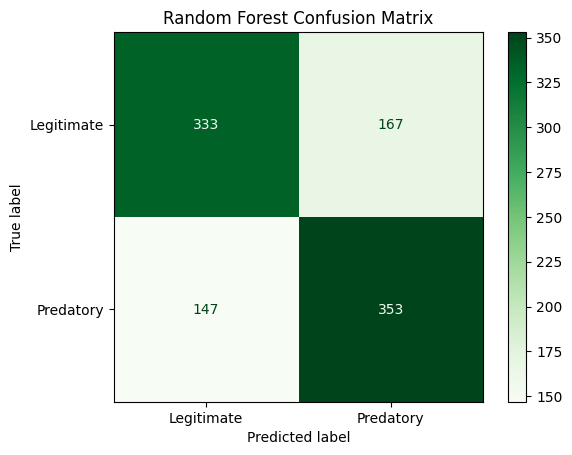

Cross-validation ROC-AUC: 0.7508 ± 0.0183
Test ROC-AUC: 0.7539
Overfitting Gap (CV - Test): -0.0031
False Positive Rate: 0.334
False Negative Rate: 0.294
Predatory Detection Rate (Recall): 0.706

✅ Random Forest evaluation complete using 8 features: ['word_count', 'grammar_errors', 'review_speed', 'readability', 'mtld', 'hdd', 'lexical_density', 'reference_count']


In [68]:
print("\n🔹 Evaluating Random Forest with model-specific RFE features")
print("="*70)

# Get model-specific data
data_rf = modeling_data_all_models['RandomForest']
X_train_rf = data_rf['X_train']
X_test_rf = data_rf['X_test']
y_train_rf = data_rf['y_train']
y_test_rf = data_rf['y_test']
selected_features_rf = data_rf['feature_columns']

# Initialize fresh model
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Cross-validation ROC-AUC
cv_roc_auc_rf = cross_val_score(rf_model, X_train_rf, y_train_rf, cv=5, scoring='roc_auc')
cv_roc_auc_rf_mean = cv_roc_auc_rf.mean()
cv_roc_auc_rf_std = cv_roc_auc_rf.std()

# Train and evaluate on test set
rf_model.fit(X_train_rf, y_train_rf)
y_pred_rf = rf_model.predict(X_test_rf)
y_pred_proba_rf = rf_model.predict_proba(X_test_rf)[:, 1]
test_roc_auc_rf = roc_auc_score(y_test_rf, y_pred_proba_rf)
overfitting_gap_rf = cv_roc_auc_rf_mean - test_roc_auc_rf

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_rf, y_pred_rf, target_names=['Legitimate', 'Predatory']))

# Confusion matrix plot
cm_rf = confusion_matrix(y_test_rf, y_pred_rf)
disp = ConfusionMatrixDisplay(cm_rf, display_labels=['Legitimate', 'Predatory'])
disp.plot(cmap='Greens', values_format='d')
plt.title("Random Forest Confusion Matrix")
plt.show()

# Business metrics
tn, fp, fn, tp = cm_rf.ravel()
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (fn + tp)
recall = tp / (tp + fn)

print(f"Cross-validation ROC-AUC: {cv_roc_auc_rf_mean:.4f} ± {cv_roc_auc_rf_std:.4f}")
print(f"Test ROC-AUC: {test_roc_auc_rf:.4f}")
print(f"Overfitting Gap (CV - Test): {overfitting_gap_rf:.4f}")
print(f"False Positive Rate: {false_positive_rate:.3f}")
print(f"False Negative Rate: {false_negative_rate:.3f}")
print(f"Predatory Detection Rate (Recall): {recall:.3f}")
print(f"\n✅ Random Forest evaluation complete using {len(selected_features_rf)} features: {selected_features_rf}")



🔹 Evaluating Gradient Boosting with model-specific RFE features

Classification Report:
              precision    recall  f1-score   support

  Legitimate       0.71      0.65      0.68       500
   Predatory       0.68      0.74      0.70       500

    accuracy                           0.69      1000
   macro avg       0.69      0.69      0.69      1000
weighted avg       0.69      0.69      0.69      1000



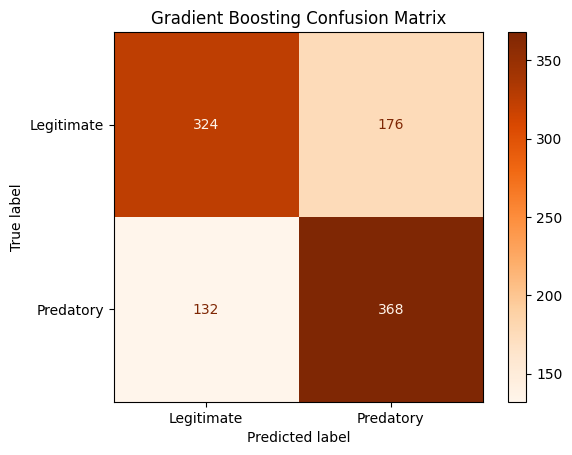

Cross-validation ROC-AUC: 0.7572 ± 0.0131
Test ROC-AUC: 0.7604
Overfitting Gap (CV - Test): -0.0032
False Positive Rate: 0.352
False Negative Rate: 0.264
Predatory Detection Rate (Recall): 0.736

✅ Gradient Boosting evaluation complete using 5 features: ['word_count', 'grammar_errors', 'review_speed', 'lexical_density', 'reference_count']


In [69]:
print("\n🔹 Evaluating Gradient Boosting with model-specific RFE features")
print("="*70)

# Get model-specific data
data_gb = modeling_data_all_models['GradientBoosting']
X_train_gb = data_gb['X_train']
X_test_gb = data_gb['X_test']
y_train_gb = data_gb['y_train']
y_test_gb = data_gb['y_test']
selected_features_gb = data_gb['feature_columns']

# Initialize fresh model
gb_model = GradientBoostingClassifier(random_state=42)

# Cross-validation ROC-AUC
cv_roc_auc_gb = cross_val_score(gb_model, X_train_gb, y_train_gb, cv=5, scoring='roc_auc')
cv_roc_auc_gb_mean = cv_roc_auc_gb.mean()
cv_roc_auc_gb_std = cv_roc_auc_gb.std()

# Train and evaluate on test set
gb_model.fit(X_train_gb, y_train_gb)
y_pred_gb = gb_model.predict(X_test_gb)
y_pred_proba_gb = gb_model.predict_proba(X_test_gb)[:, 1]
test_roc_auc_gb = roc_auc_score(y_test_gb, y_pred_proba_gb)
overfitting_gap_gb = cv_roc_auc_gb_mean - test_roc_auc_gb

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_gb, y_pred_gb, target_names=['Legitimate', 'Predatory']))

# Confusion matrix plot
cm_gb = confusion_matrix(y_test_gb, y_pred_gb)
disp = ConfusionMatrixDisplay(cm_gb, display_labels=['Legitimate', 'Predatory'])
disp.plot(cmap='Oranges', values_format='d')
plt.title("Gradient Boosting Confusion Matrix")
plt.show()

# Business metrics
tn, fp, fn, tp = cm_gb.ravel()
false_positive_rate = fp / (fp + tn)
false_negative_rate = fn / (fn + tp)
recall = tp / (tp + fn)

print(f"Cross-validation ROC-AUC: {cv_roc_auc_gb_mean:.4f} ± {cv_roc_auc_gb_std:.4f}")
print(f"Test ROC-AUC: {test_roc_auc_gb:.4f}")
print(f"Overfitting Gap (CV - Test): {overfitting_gap_gb:.4f}")
print(f"False Positive Rate: {false_positive_rate:.3f}")
print(f"False Negative Rate: {false_negative_rate:.3f}")
print(f"Predatory Detection Rate (Recall): {recall:.3f}")
print(f"\n✅ Gradient Boosting evaluation complete using {len(selected_features_gb)} features: {selected_features_gb}")


In [70]:
from sklearn.model_selection import GridSearchCV

print("\n🔹 Hyperparameter Tuning: Random Forest")
print("="*60)

# Use RF-specific features
X_train_rf = modeling_data_all_models['RandomForest']['X_train']
y_train_rf = modeling_data_all_models['RandomForest']['y_train']

rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Define grid
rf_param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_grid = GridSearchCV(
    estimator=rf_model,
    param_grid=rf_param_grid,
    scoring='roc_auc',
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1
)

rf_grid.fit(X_train_rf, y_train_rf)

print(f"\n✅ Best Random Forest Hyperparameters:\n{rf_grid.best_params_}")
print(f"Best CV ROC-AUC: {rf_grid.best_score_:.4f}")



🔹 Hyperparameter Tuning: Random Forest
Fitting 5 folds for each of 324 candidates, totalling 1620 fits

✅ Best Random Forest Hyperparameters:
{'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}
Best CV ROC-AUC: 0.7607


Cross-validation ROC-AUC: 0.7553 ± 0.0168
Test ROC-AUC: 0.7629
Overfitting Gap (CV - Test): -0.0076
False Positive Rate: 0.338
False Negative Rate: 0.256
Predatory Detection Rate (Recall): 0.744
✅ Random Forest evaluation complete using 8 features


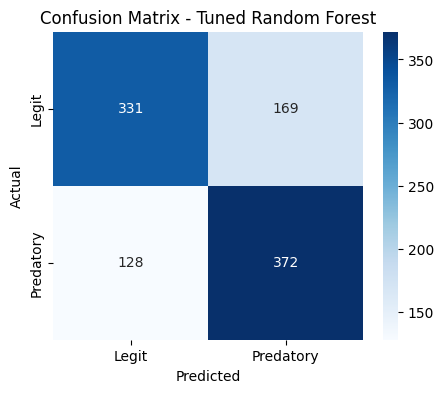

In [71]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# --- Use best RF from GridSearchCV ---
best_rf = rf_grid.best_estimator_

# --- Use model-specific RFE features ---
X_train_rf = modeling_data_all_models['RandomForest']['X_train']
X_test_rf  = modeling_data_all_models['RandomForest']['X_test']
y_train_rf = modeling_data_all_models['RandomForest']['y_train']
y_test_rf  = modeling_data_all_models['RandomForest']['y_test']

# --- Cross-validated ROC-AUC on training ---
cv_scores = cross_val_score(best_rf, X_train_rf, y_train_rf, cv=5, scoring='roc_auc')
cv_mean = cv_scores.mean()
cv_std  = cv_scores.std()

# --- Test set ROC-AUC ---
best_rf.fit(X_train_rf, y_train_rf)
y_pred_proba = best_rf.predict_proba(X_test_rf)[:,1]
test_roc_auc = roc_auc_score(y_test_rf, y_pred_proba)

# --- Overfitting gap ---
overfitting_gap = cv_mean - test_roc_auc

# --- Predictions & confusion matrix ---
y_pred = best_rf.predict(X_test_rf)
cm = confusion_matrix(y_test_rf, y_pred)
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)
recall = tp / (tp + fn)

# --- Display results ---
print(f"Cross-validation ROC-AUC: {cv_mean:.4f} ± {cv_std:.4f}")
print(f"Test ROC-AUC: {test_roc_auc:.4f}")
print(f"Overfitting Gap (CV - Test): {overfitting_gap:.4f}")
print(f"False Positive Rate: {fpr:.3f}")
print(f"False Negative Rate: {fnr:.3f}")
print(f"Predatory Detection Rate (Recall): {recall:.3f}")
print(f"✅ Random Forest evaluation complete using {X_train_rf.shape[1]} features")

# --- Optional: Confusion Matrix Plot ---
import seaborn as sns
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legit','Predatory'], yticklabels=['Legit','Predatory'])
plt.title('Confusion Matrix - Tuned Random Forest')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()


In [72]:
print("\n🔹 Hyperparameter Tuning: Gradient Boosting")
print("="*60)

# Use GB-specific features
X_train_gb = modeling_data_all_models['GradientBoosting']['X_train']
y_train_gb = modeling_data_all_models['GradientBoosting']['y_train']

gb_model = GradientBoostingClassifier(random_state=42)

# Define grid
gb_param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0]
}

gb_grid = GridSearchCV(
    estimator=gb_model,
    param_grid=gb_param_grid,
    scoring='roc_auc',
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1
)

gb_grid.fit(X_train_gb, y_train_gb)

print(f"\n✅ Best Gradient Boosting Hyperparameters:\n{gb_grid.best_params_}")
print(f"Best CV ROC-AUC: {gb_grid.best_score_:.4f}")



🔹 Hyperparameter Tuning: Gradient Boosting
Fitting 5 folds for each of 729 candidates, totalling 3645 fits

✅ Best Gradient Boosting Hyperparameters:
{'learning_rate': 0.01, 'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 300, 'subsample': 0.6}
Best CV ROC-AUC: 0.7592


Cross-validation ROC-AUC: 0.7560 ± 0.0136
Test ROC-AUC: 0.7654
Overfitting Gap (CV - Test): -0.0094
False Positive Rate: 0.340
False Negative Rate: 0.268
Predatory Detection Rate (Recall): 0.732
✅ Gradient Boosting evaluation complete using 5 features


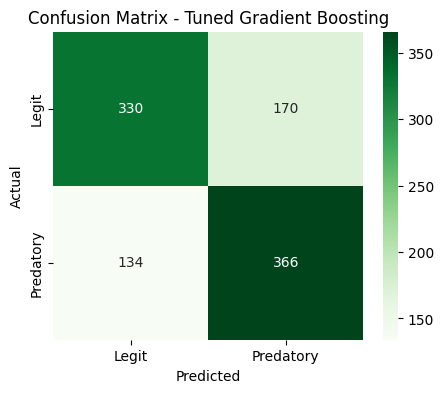

In [73]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

# --- Use best GB from GridSearchCV ---
best_gb = gb_grid.best_estimator_

# --- Use model-specific RFE features ---
X_train_gb = modeling_data_all_models['GradientBoosting']['X_train']
X_test_gb  = modeling_data_all_models['GradientBoosting']['X_test']
y_train_gb = modeling_data_all_models['GradientBoosting']['y_train']
y_test_gb  = modeling_data_all_models['GradientBoosting']['y_test']

# --- Cross-validated ROC-AUC on training ---
cv_scores = cross_val_score(best_gb, X_train_gb, y_train_gb, cv=5, scoring='roc_auc')
cv_mean = cv_scores.mean()
cv_std  = cv_scores.std()

# --- Test set ROC-AUC ---
best_gb.fit(X_train_gb, y_train_gb)
y_pred_proba = best_gb.predict_proba(X_test_gb)[:,1]
test_roc_auc = roc_auc_score(y_test_gb, y_pred_proba)

# --- Overfitting gap ---
overfitting_gap = cv_mean - test_roc_auc

# --- Predictions & confusion matrix ---
y_pred = best_gb.predict(X_test_gb)
cm = confusion_matrix(y_test_gb, y_pred)
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)
recall = tp / (tp + fn)

# --- Display results ---
print(f"Cross-validation ROC-AUC: {cv_mean:.4f} ± {cv_std:.4f}")
print(f"Test ROC-AUC: {test_roc_auc:.4f}")
print(f"Overfitting Gap (CV - Test): {overfitting_gap:.4f}")
print(f"False Positive Rate: {fpr:.3f}")
print(f"False Negative Rate: {fnr:.3f}")
print(f"Predatory Detection Rate (Recall): {recall:.3f}")
print(f"✅ Gradient Boosting evaluation complete using {X_train_gb.shape[1]} features")

# --- Optional: Confusion Matrix Plot ---
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Legit','Predatory'], yticklabels=['Legit','Predatory'])
plt.title('Confusion Matrix - Tuned Gradient Boosting')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()



📊 BUILT-IN FEATURE IMPORTANCE (Gini-based):


,Feature,Importance
2,review_speed,0.304124
0,word_count,0.235527
3,lexical_density,0.175367
4,reference_count,0.147217
1,grammar_errors,0.137766



📊 TEST SET PERFORMANCE:
ROC-AUC: 0.7654
Precision: 0.6828
Recall: 0.7320
F1-Score: 0.7066
Accuracy: 0.6960

📋 CONFUSION MATRIX:
TN: 330, FP: 170, FN: 134, TP: 366
False Positive Rate: 0.340
False Negative Rate: 0.268


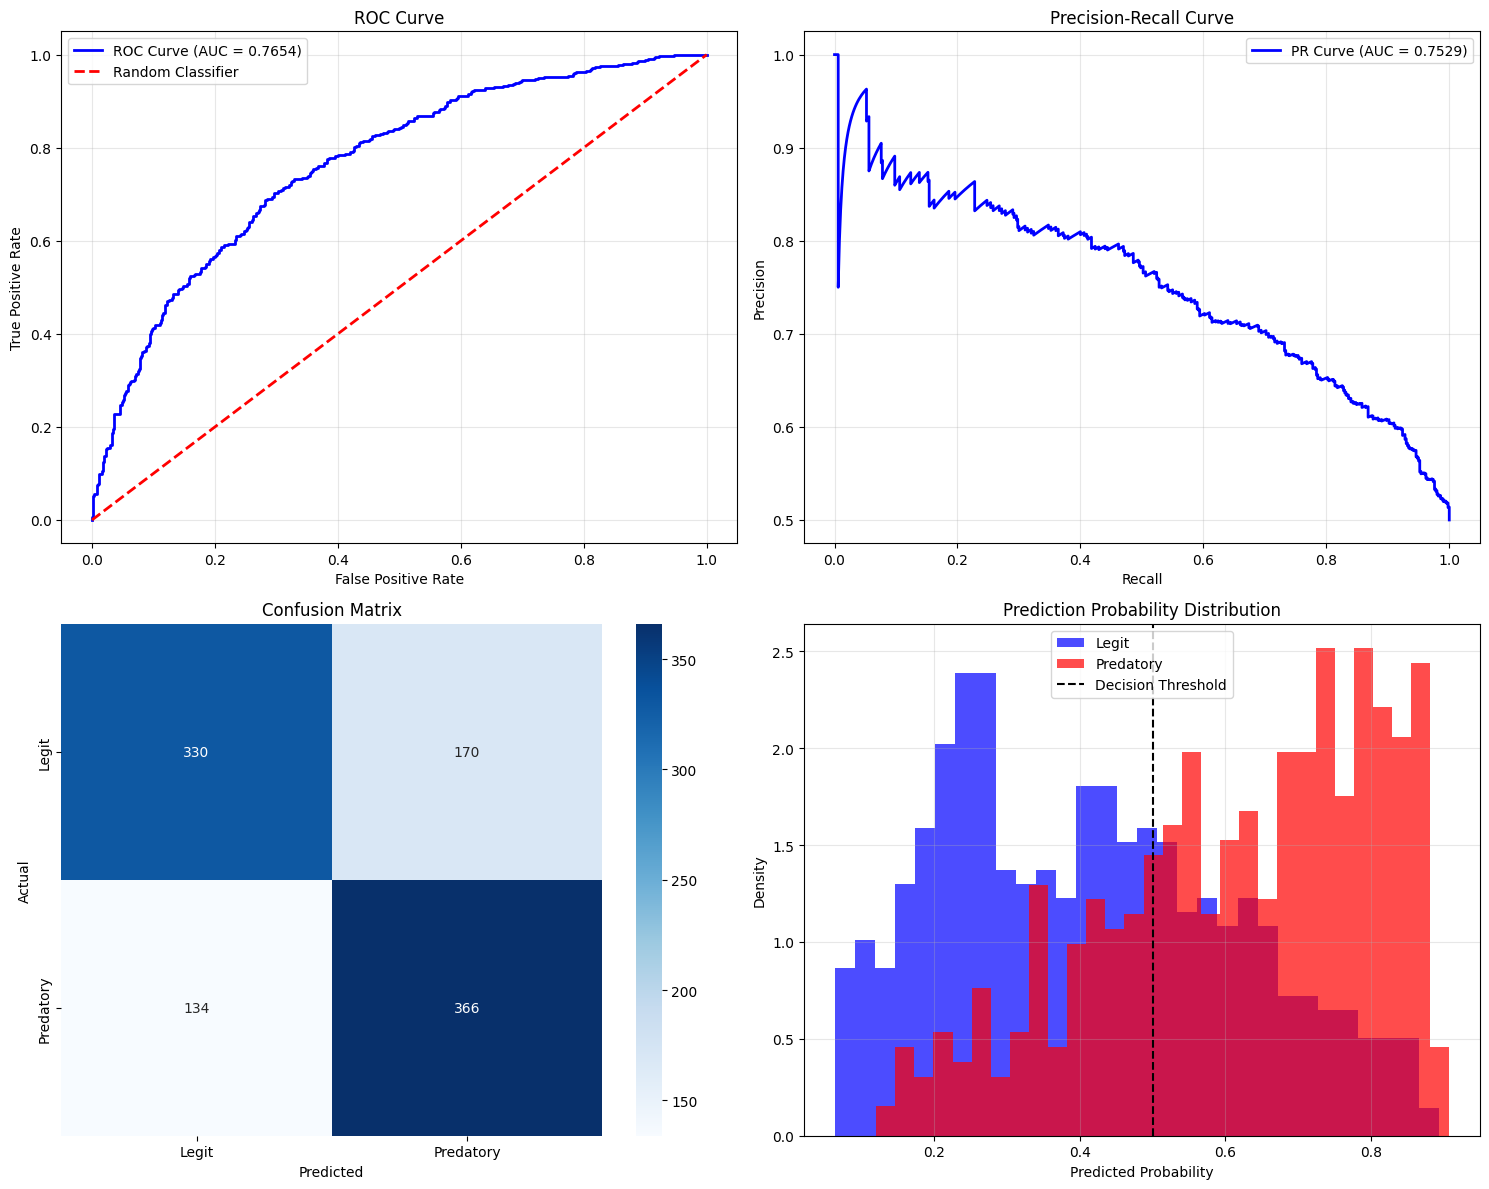


📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

  Legitimate     0.7112    0.6600    0.6846       500
   Predatory     0.6828    0.7320    0.7066       500

    accuracy                         0.6960      1000
   macro avg     0.6970    0.6960    0.6956      1000
weighted avg     0.6970    0.6960    0.6956      1000



In [79]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, roc_curve, precision_recall_curve, auc


# --- Use best GB from GridSearchCV ---
# best_gb = gb_grid.best_estimator_

# --- Use model-specific RFE features ---
X_train_gb = modeling_data_all_models['GradientBoosting']['X_train']
X_test_gb  = modeling_data_all_models['GradientBoosting']['X_test']
y_train_gb = modeling_data_all_models['GradientBoosting']['y_train']
y_test_gb  = modeling_data_all_models['GradientBoosting']['y_test']

feature_names = X_train_gb.columns.tolist()

# --- Train best GB on full training data ---
best_gb.fit(X_train_gb, y_train_gb)

# --- Built-in feature importance ---
builtin_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': best_gb.feature_importances_
}).sort_values('Importance', ascending=False)

print(f"\n📊 BUILT-IN FEATURE IMPORTANCE (Gini-based):")
display(builtin_importance)

# --- Predictions on test set ---
y_pred = best_gb.predict(X_test_gb)
y_pred_proba = best_gb.predict_proba(X_test_gb)[:, 1]

# --- Metrics ---
test_roc_auc = roc_auc_score(y_test_gb, y_pred_proba)
test_precision = precision_score(y_test_gb, y_pred)
test_recall = recall_score(y_test_gb, y_pred)
test_f1 = f1_score(y_test_gb, y_pred)
test_accuracy = accuracy_score(y_test_gb, y_pred)

print(f"\n📊 TEST SET PERFORMANCE:")
print(f"ROC-AUC: {test_roc_auc:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")
print(f"Accuracy: {test_accuracy:.4f}")

# --- Confusion matrix ---
cm = confusion_matrix(y_test_gb, y_pred)
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)
fnr = fn / (fn + tp)

print(f"\n📋 CONFUSION MATRIX:")
print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
print(f"False Positive Rate: {fpr:.3f}")
print(f"False Negative Rate: {fnr:.3f}")

# --- Performance visualization ---
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# ROC Curve
fpr_curve, tpr_curve, _ = roc_curve(y_test_gb, y_pred_proba)
axes[0, 0].plot(fpr_curve, tpr_curve, color='blue', lw=2, label=f'ROC Curve (AUC = {test_roc_auc:.4f})')
axes[0, 0].plot([0,1], [0,1], color='red', lw=2, linestyle='--', label='Random Classifier')
axes[0, 0].set_title('ROC Curve')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Precision-Recall Curve
precision_curve, recall_curve, _ = precision_recall_curve(y_test_gb, y_pred_proba)
pr_auc = auc(recall_curve, precision_curve)
axes[0, 1].plot(recall_curve, precision_curve, color='blue', lw=2, label=f'PR Curve (AUC = {pr_auc:.4f})')
axes[0, 1].set_title('Precision-Recall Curve')
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Confusion matrix heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Legit','Predatory'],
            yticklabels=['Legit','Predatory'],
            ax=axes[1, 0])
axes[1, 0].set_title('Confusion Matrix')
axes[1, 0].set_xlabel('Predicted')
axes[1, 0].set_ylabel('Actual')

# Prediction probability distribution
axes[1, 1].hist(y_pred_proba[y_test_gb==0], bins=30, alpha=0.7, label='Legit', color='blue', density=True)
axes[1, 1].hist(y_pred_proba[y_test_gb==1], bins=30, alpha=0.7, label='Predatory', color='red', density=True)
axes[1, 1].axvline(x=0.5, color='black', linestyle='--', label='Decision Threshold')
axes[1, 1].set_title('Prediction Probability Distribution')
axes[1, 1].set_xlabel('Predicted Probability')
axes[1, 1].set_ylabel('Density')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- Classification report ---
print(f"\n📋 CLASSIFICATION REPORT:")
print(classification_report(y_test_gb, y_pred, target_names=['Legitimate','Predatory'], digits=4))


In [80]:
import joblib

# Define filename
model_filename = "final_gradient_boosting.pkl"

# Save the model
joblib.dump(best_gb, model_filename)

print(f"✅ Best Gradient Boosting model saved as '{model_filename}'")


✅ Best Gradient Boosting model saved as 'final_gradient_boosting.pkl'
